 # DQN Training in Maze Environment (Hyperparameterized)

In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import itertools
from collections import deque


 ## Hyperparameters

In [2]:
hyperparams = {
    "learning_rate": [5e-5, 1e-5, 1e-4],
    "gamma": [0.96,0.96, 0.98],
    "epsilon_decay_episodes": [0.85, 0.9, 0.95],
    "batch_size": [128, 256],
    "replay_buffer_size": [10000],
    "episodes": [8000, 10000],
    "hidden_layers": [
        [64, 64, 64], 
        [128, 128, 128], 
        [128, 128], 
    ],
    "activation": ["elu"]
}

def generate_param_combinations(grid):
    keys = list(grid.keys())
    values = list(grid.values())
    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))

shared_params = {
    "epsilon_start": 1.0,
    "epsilon_min": 0.01,
    "replay_buffer_size": 8000,
    "steps_per_episode": 3000,
    "target_update_freq": 500,
    "random_seed": 42,
    "maze_width": 10,
    "maze_height": 10,
    "maze_imperfections": 5,
    "input_dim": 19,
    "n_outputs": 4,
    "log_every": 11000,
    "q_log_every": 11000,
    "plot_every": 11000,
    "train_after": 0.33333
}


# Constants

In [3]:
random_seed = 42
maze_width = 16
maze_height = 16
input_shape = 19
n_outputs = 4


 ## Maze Setup

In [4]:
np.random.seed(random_seed)

env = maze_library.init_environment_python(maze_width, maze_height, 5)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)


 ## Model Definition

In [5]:
activation_map = {
    "relu": nn.ReLU,
    "elu": nn.ELU,
    "tanh": nn.Tanh,
    "sigmoid": nn.Sigmoid,
    # Add more if needed
}

class DQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers=[64, 64, 64], activation="elu"):
        super(DQN, self).__init__()
        self.model = nn.Sequential()
        
        prev_size = input_size
        for i, hidden_size in enumerate(hidden_layers):
            self.model.add_module(f"fc{i}", nn.Linear(prev_size, hidden_size))
            self.model.add_module(f"act{i}", activation_map[activation]())
            prev_size = hidden_size
        
        self.model.add_module("output", nn.Linear(prev_size, output_size))

    def forward(self, x):
        return self.model(x)


def create_model(hyperprm):
    model = DQN(input_shape, n_outputs, hyperprm["hidden_layers"], hyperprm["activation"])
    optimizer = torch.optim.NAdam(model.parameters(), lr=5e-5)
    loss_fn = nn.HuberLoss()

    return model, optimizer, loss_fn


 ## Policy and Replay Buffer

In [6]:

def epsilon_greedy_policy(state, epsilon, model):
    if random.random() < epsilon:
        return random.randint(0, n_outputs - 1)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = model(state_tensor)
        return int(torch.argmax(q_values).item())

def sample_experiences(batch_size, replay_buffer):
    indices = np.random.choice(len(replay_buffer), min(batch_size, len(replay_buffer)), replace=False)
    batch = [replay_buffer[i] for i in indices]
    return zip(*batch)


In [7]:


def play_one_step(env, state, epsilon,model, replay_buffer, reward_log):
    action = epsilon_greedy_policy(state, epsilon, model)
    action_obj = maze_library.create_action(action, 0)
    next_state, reward, done, truncated = env.take_action(action_obj)
    reward_log.append(reward)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated


In [8]:
def training_step(model, optimizer, loss_fn, hyperprm, replay_buffer, q_value_log):
    states, actions, rewards, next_states, dones, truncateds = sample_experiences(hyperprm["batch_size"], replay_buffer)

    states = torch.tensor(np.array(states), dtype=torch.float32)
    actions = torch.tensor(np.array(actions), dtype=torch.int64)
    rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
    next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
    dones = torch.tensor(np.array(dones), dtype=torch.float32)
    truncateds = torch.tensor(np.array(truncateds), dtype=torch.float32)

    with torch.no_grad():
        next_q = model(next_states)
        max_next_q = next_q.max(dim=1)[0]
        terminal = torch.logical_or(dones.bool(), truncateds.bool()).float()
        target_q = rewards + (1 - terminal) * hyperprm["gamma"] * max_next_q

    q_values = model(states)
    selected_q = q_values.gather(1, actions.unsqueeze(1)).squeeze()
    loss = loss_fn(selected_q, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    q_value_log.extend(selected_q.detach().numpy())


In [9]:
def plot_q_values(q_value_log):
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


 ## Training Loop

In [ ]:
def run_single_experiment(hyperprm, run_id):
    all_episode_rewards  = []
    reward_log = []
    q_value_log = []
    best_weights = None
    highest_reward = -float("inf")
    model, optimizer, loss_fn = create_model(hyperprm)
    replay_buffer = deque(maxlen=hyperprm["replay_buffer_size"])
    print(f"Run {run_id}, Episodes: {hyperprm['episodes']}")

    for episode in range(hyperprm["episodes"]):
        obs, reward, done, truncated = env.reset()
        cumulative_reward = 0

        for step in range(hyperprm["steps_per_episode"]):
            eps_decay = episode / (hyperprm["episodes"] * hyperprm["epsilon_decay_episodes"])
            epsilon = max(hyperprm["epsilon_start"] - eps_decay, hyperprm["epsilon_min"])
            obs, reward, done, truncated = play_one_step(env, obs, epsilon,model, replay_buffer, reward_log)
            cumulative_reward += reward
            if done or truncated:
                break

        if episode > (hyperprm["episodes"] * hyperprm["train_after"]):
            training_step(model, optimizer, loss_fn, hyperprm, replay_buffer, q_value_log)
        
        if cumulative_reward > highest_reward:
            highest_reward = cumulative_reward
            best_weights = model.state_dict()

        if episode % hyperprm["log_every"] == 0 and episode != 0:
            print(f"Run {run_id}, Reward: {np.average(all_episode_rewards[-100:])}")

        # if episode % hyperprm["q_log_every"] == 0 and episode > 0:

        all_episode_rewards.append(cumulative_reward)
    model.load_state_dict(best_weights)
    
    plot_q_values(q_value_log)

    return {
        "params": hyperprm,
        "rewards": all_episode_rewards,
        "q_values": q_value_log,
        "final_model": model,
    }


: 

Totals combinations = 324


Run 0, Episodes: 8000


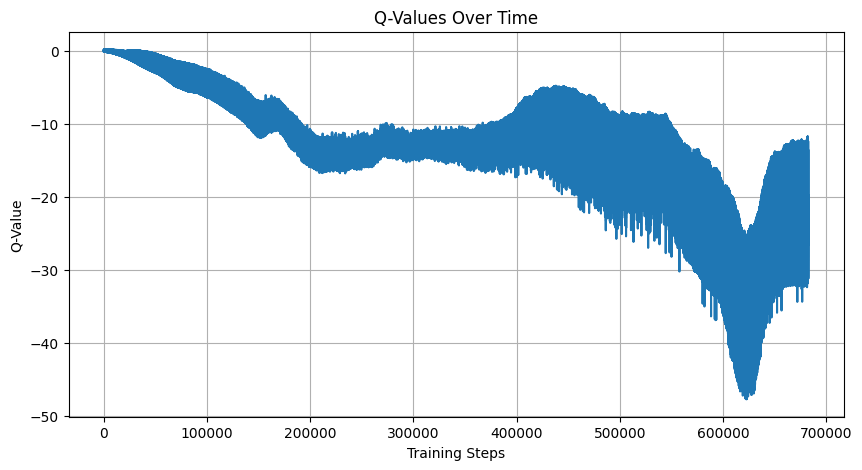

Run 1, Episodes: 8000


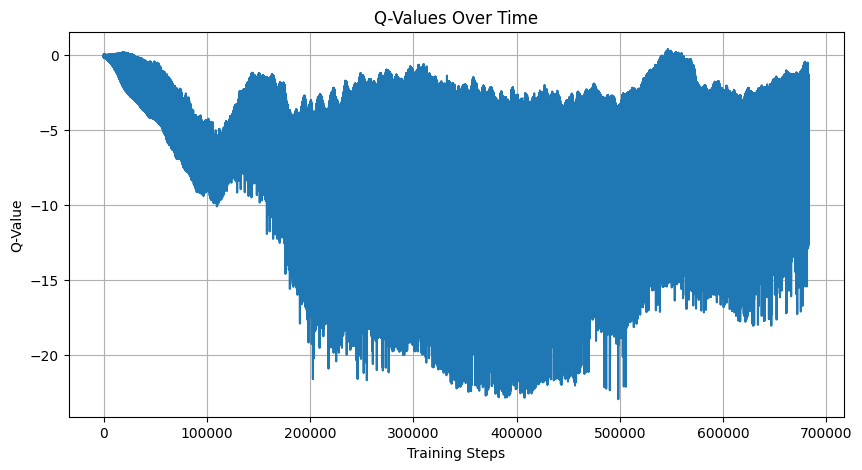

Run 2, Episodes: 8000


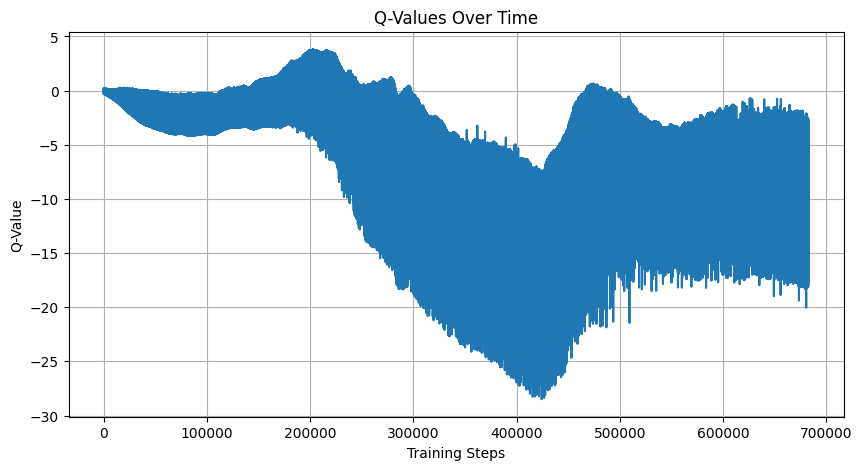

Run 3, Episodes: 10000


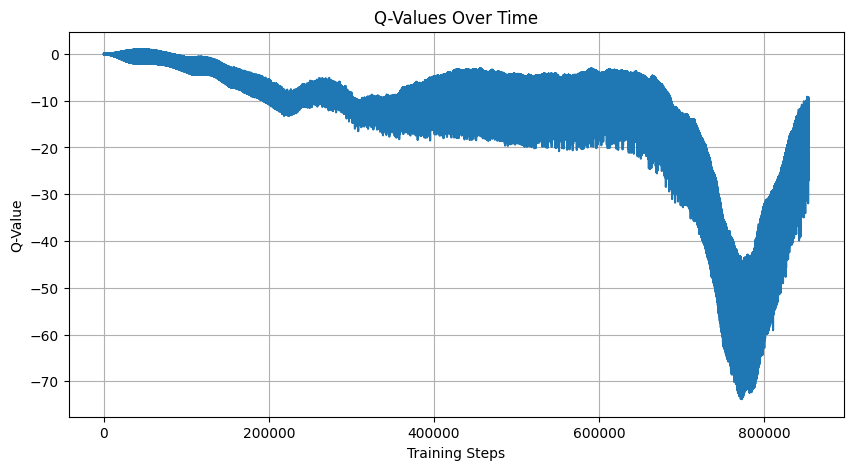

Run 4, Episodes: 10000


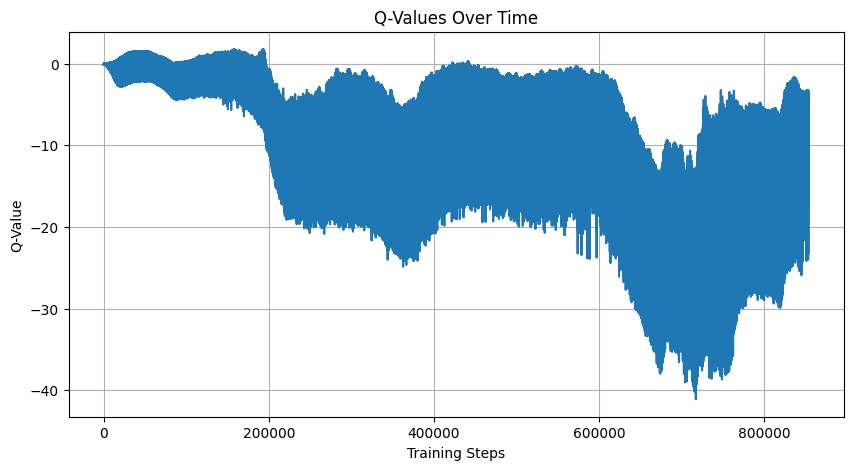

Run 5, Episodes: 10000


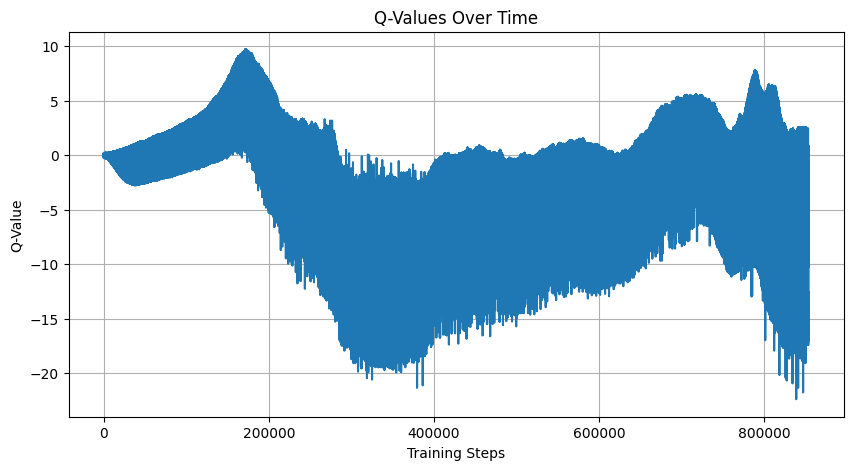

Run 6, Episodes: 8000


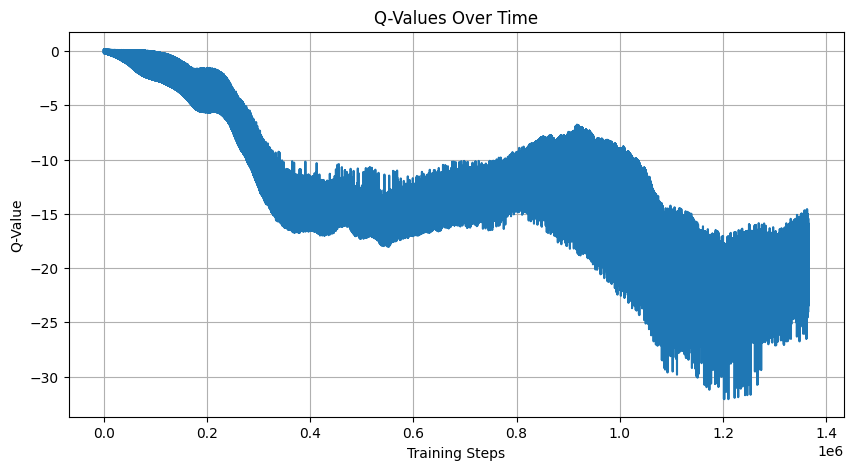

Run 7, Episodes: 8000


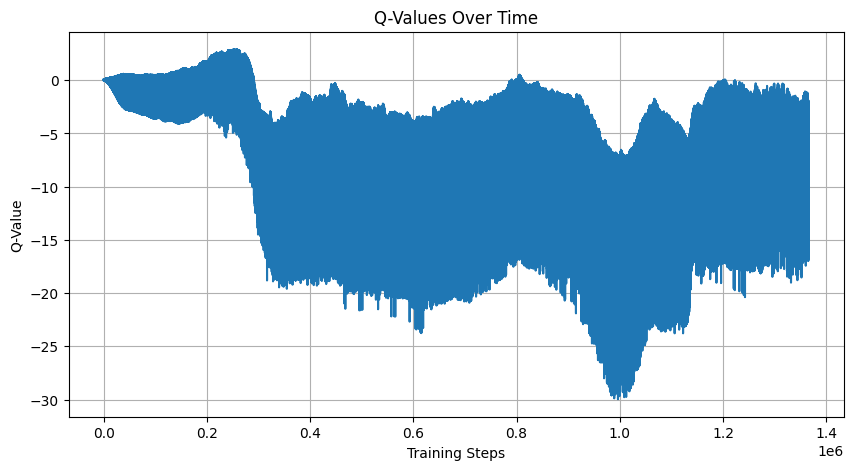

Run 8, Episodes: 8000


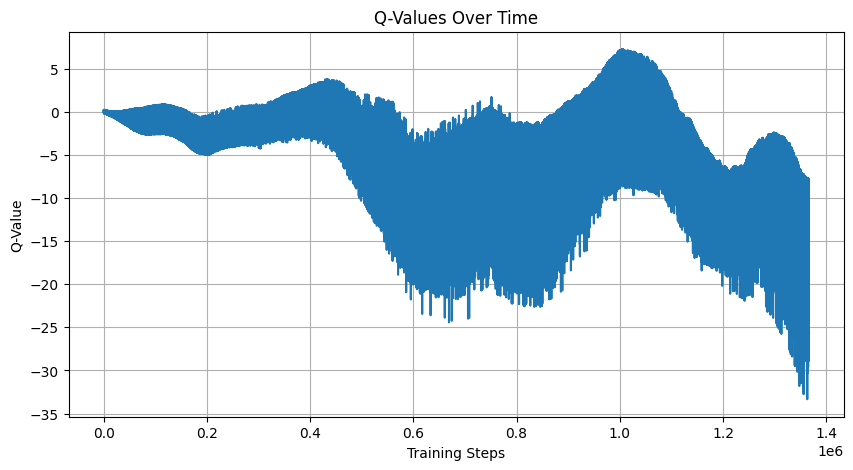

Run 9, Episodes: 10000


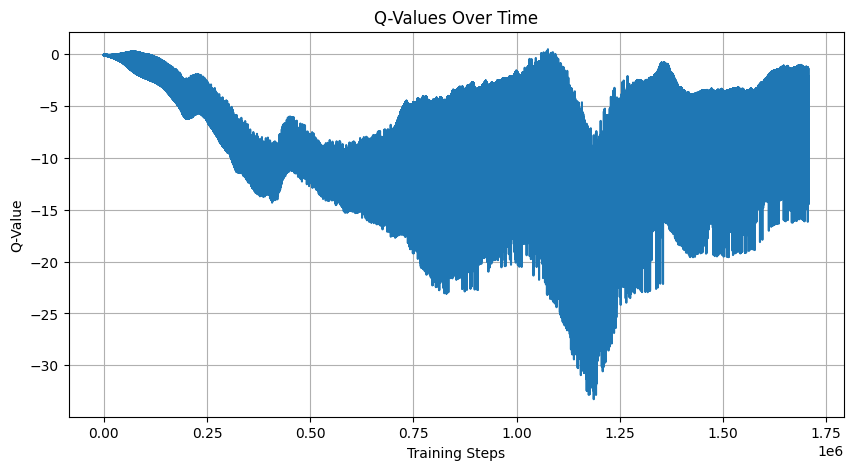

Run 10, Episodes: 10000


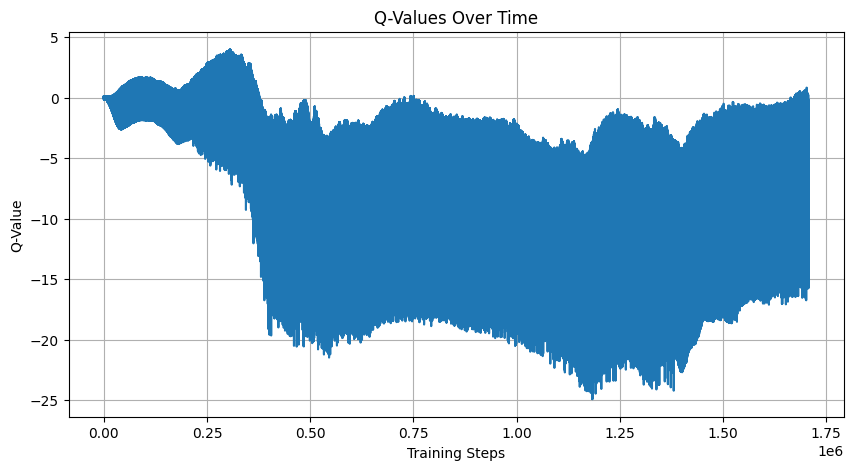

Run 11, Episodes: 10000


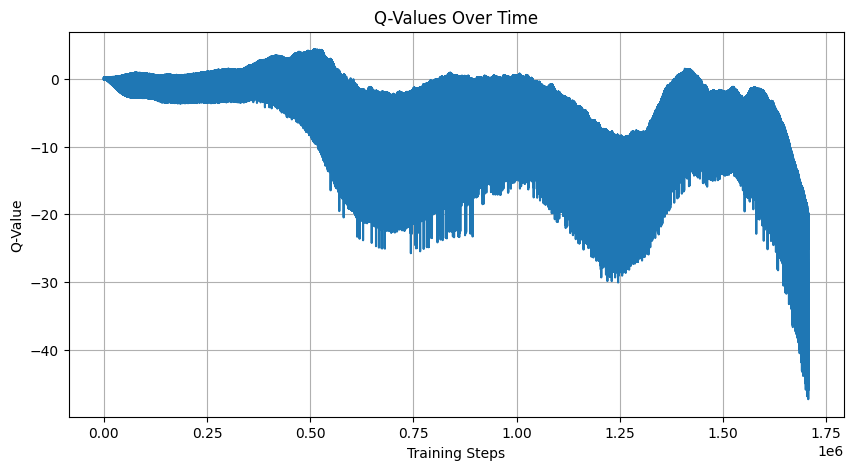

Run 12, Episodes: 8000


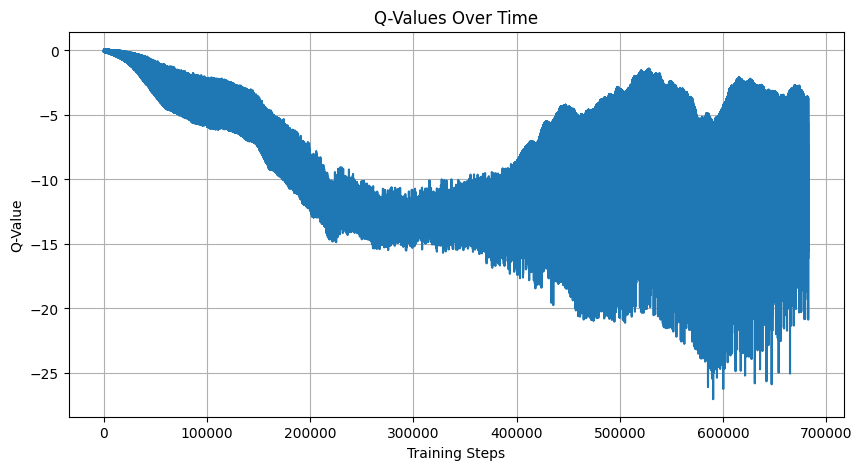

Run 13, Episodes: 8000


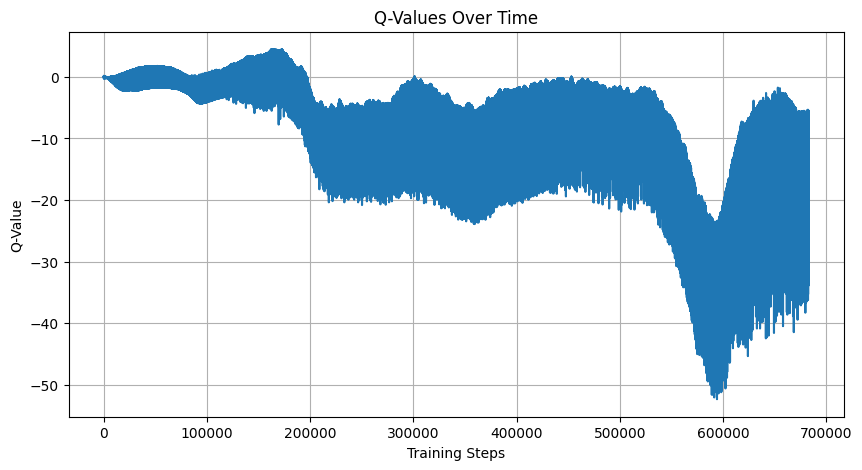

Run 14, Episodes: 8000


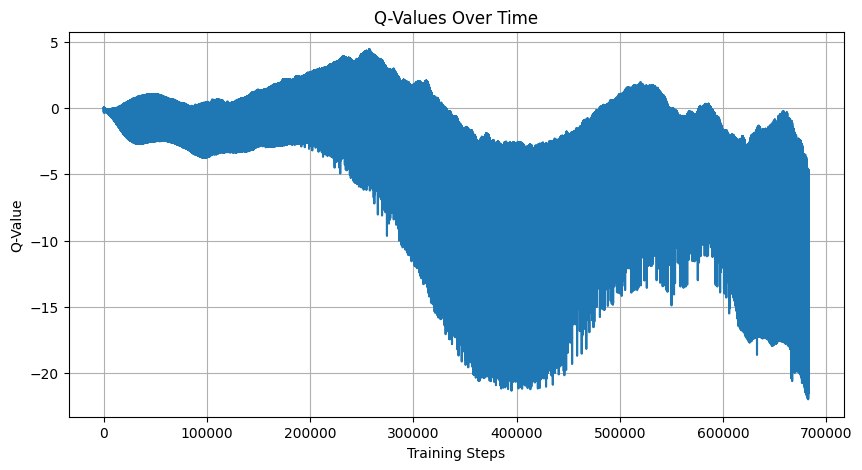

Run 15, Episodes: 10000


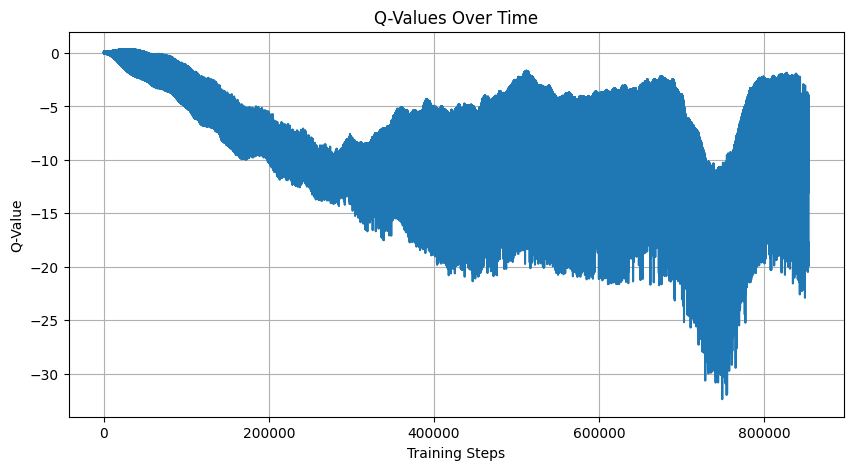

Run 16, Episodes: 10000


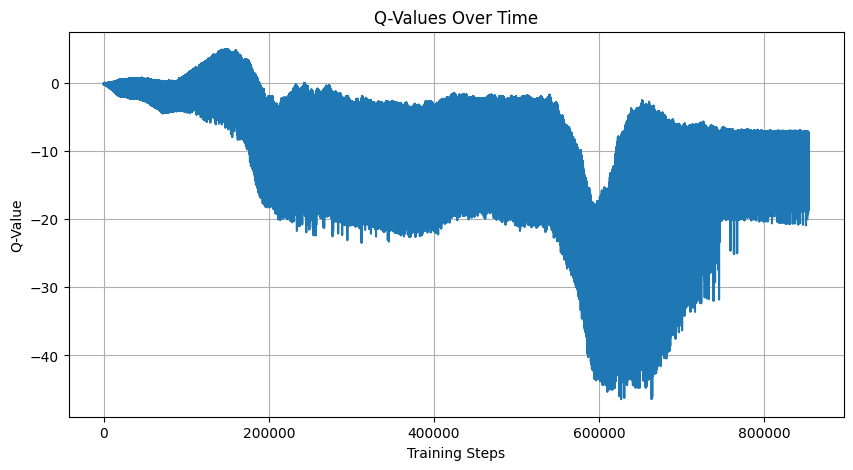

Run 17, Episodes: 10000


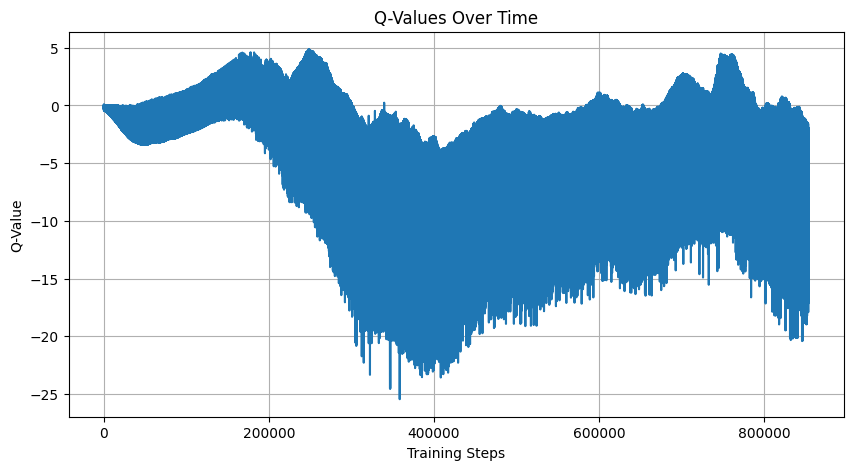

Run 18, Episodes: 8000


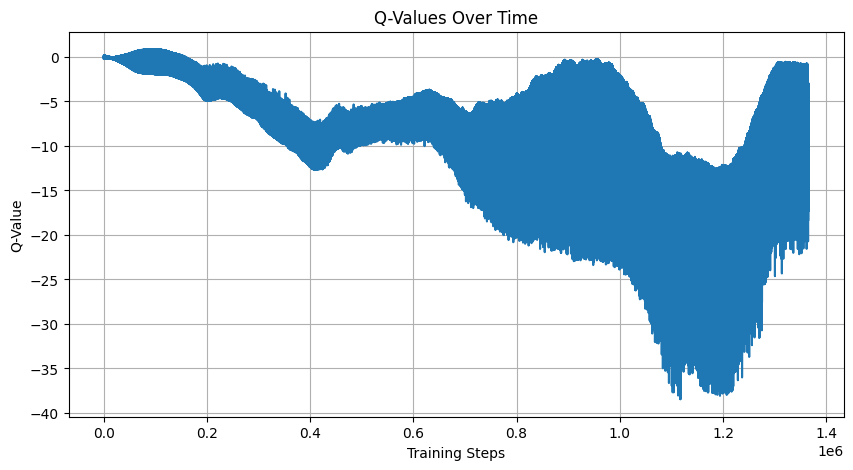

Run 19, Episodes: 8000


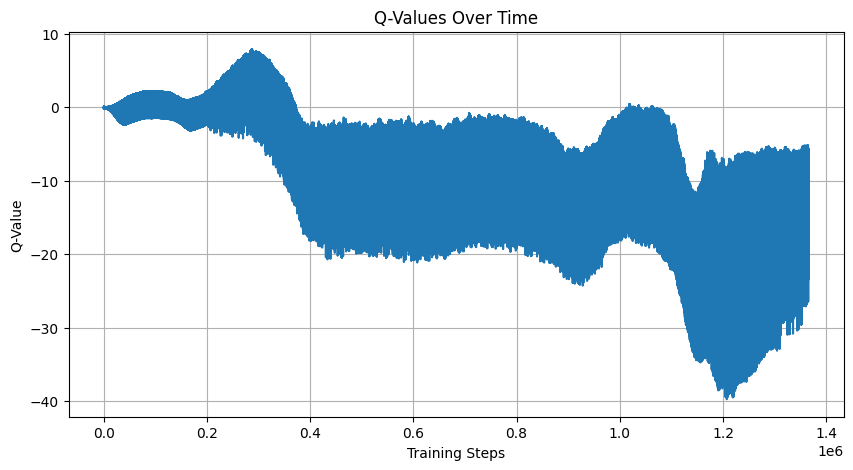

Run 20, Episodes: 8000


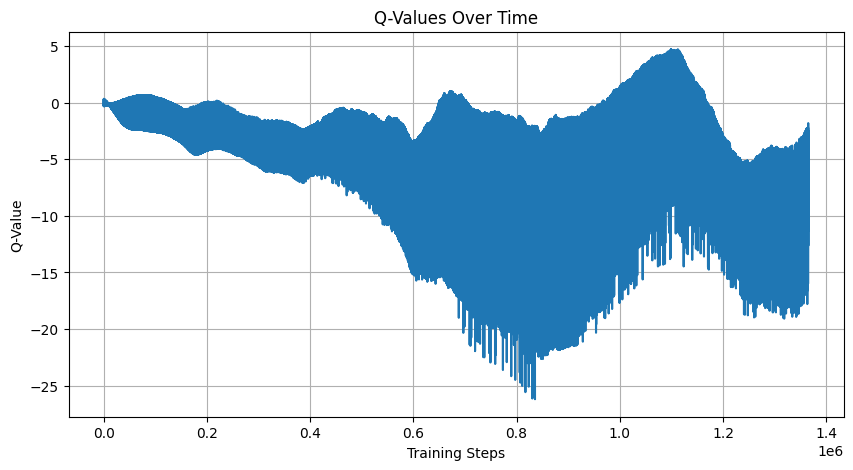

Run 21, Episodes: 10000


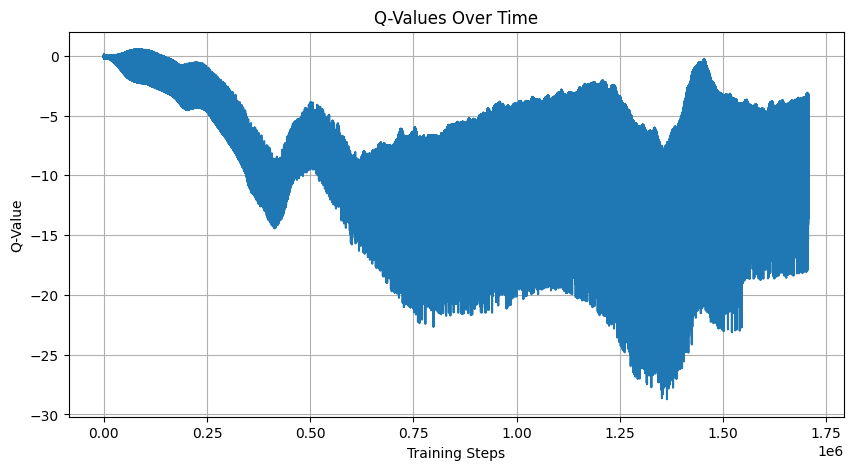

Run 22, Episodes: 10000


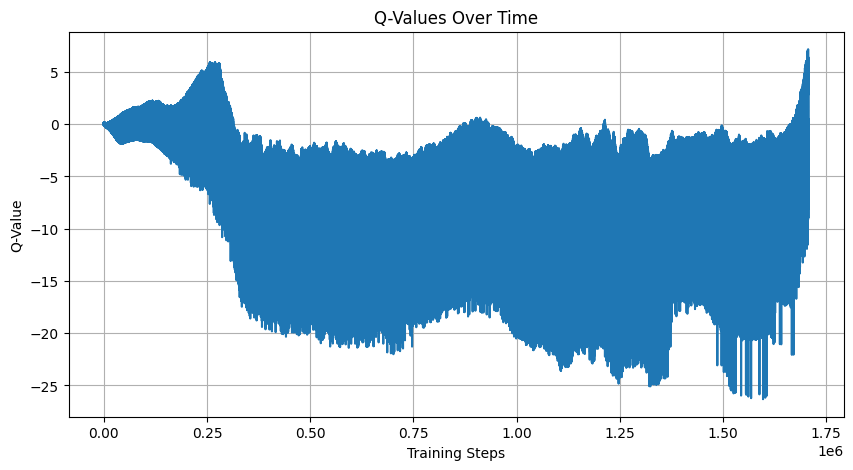

Run 23, Episodes: 10000


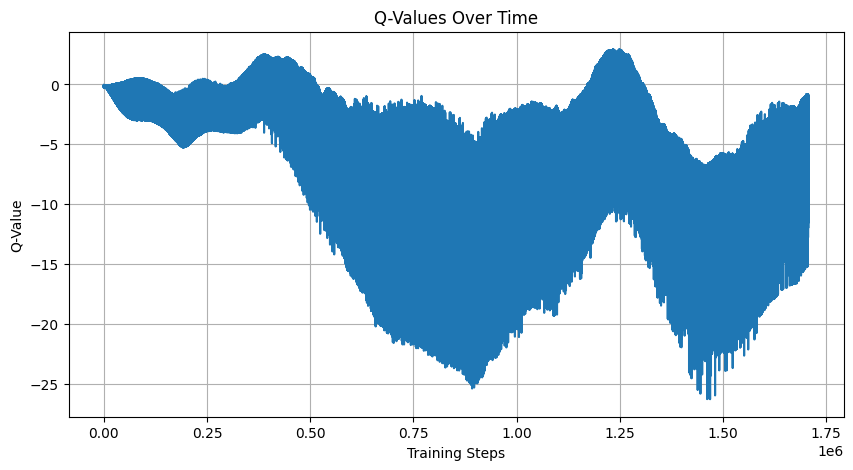

Run 24, Episodes: 8000


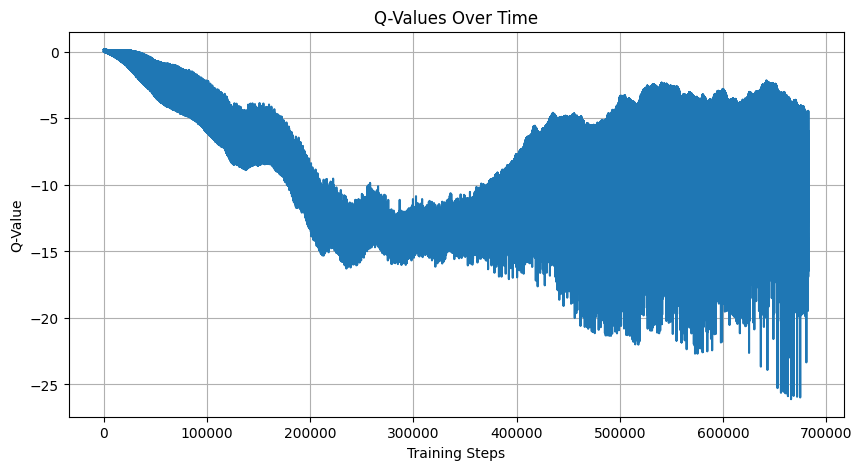

Run 25, Episodes: 8000


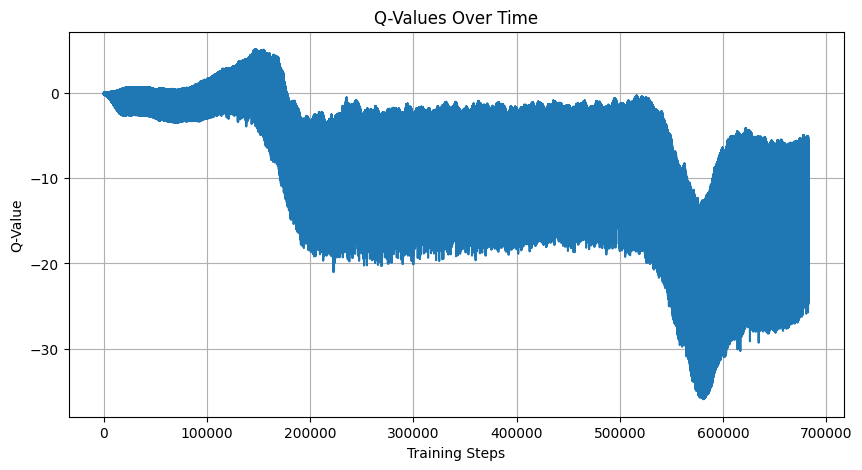

Run 26, Episodes: 8000


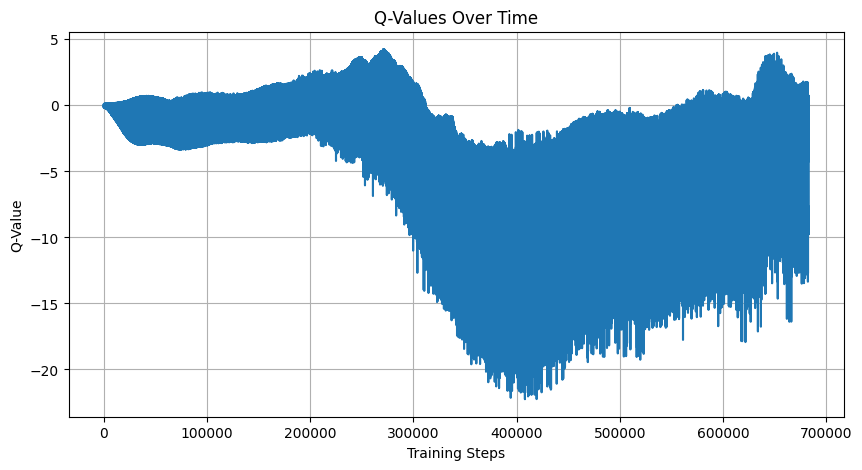

Run 27, Episodes: 10000


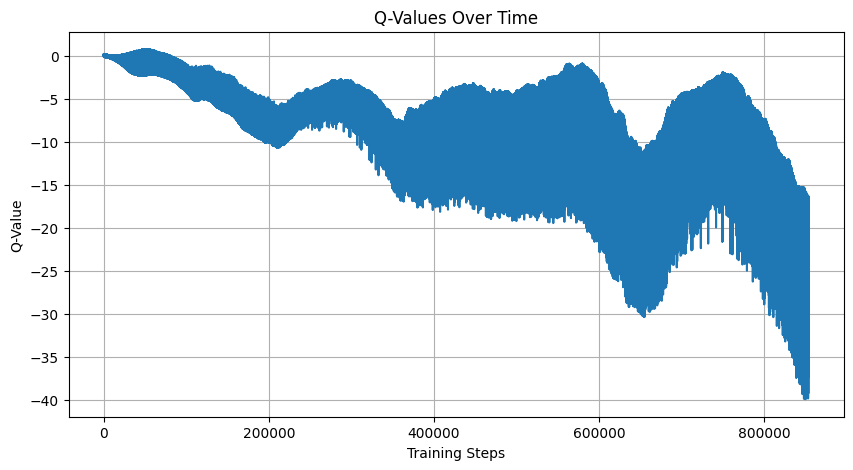

Run 28, Episodes: 10000


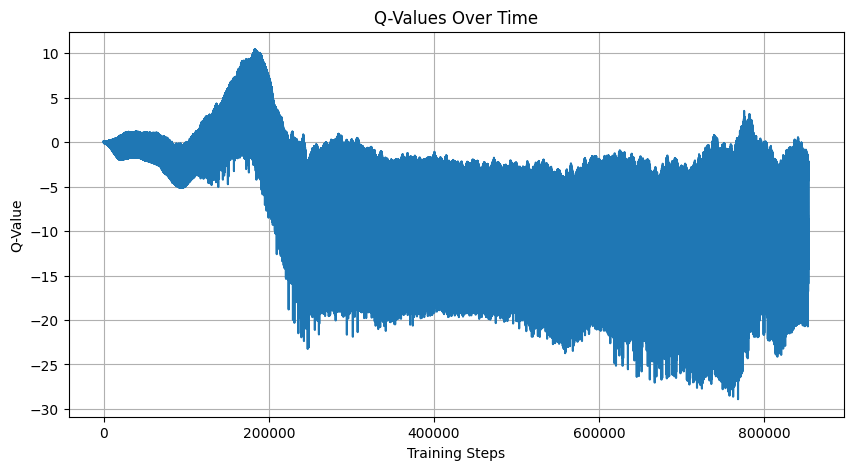

Run 29, Episodes: 10000


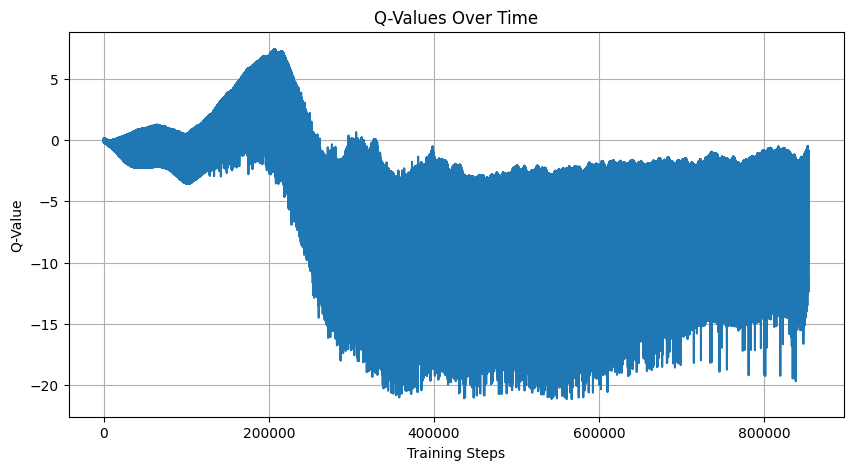

Run 30, Episodes: 8000


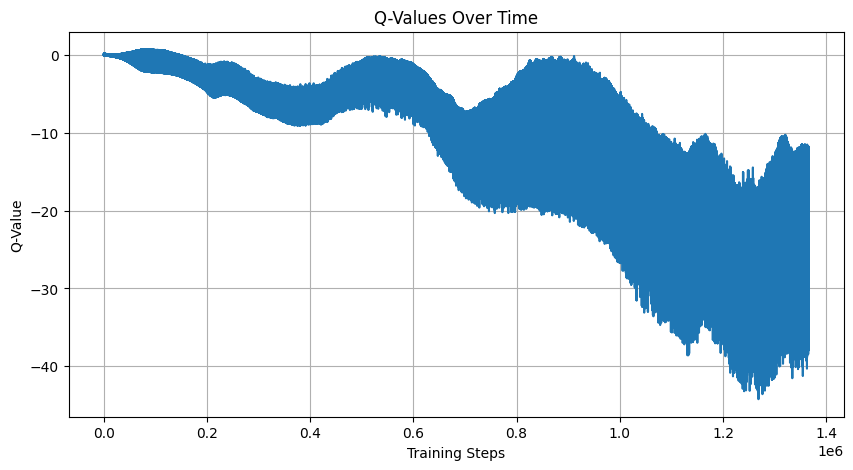

Run 31, Episodes: 8000


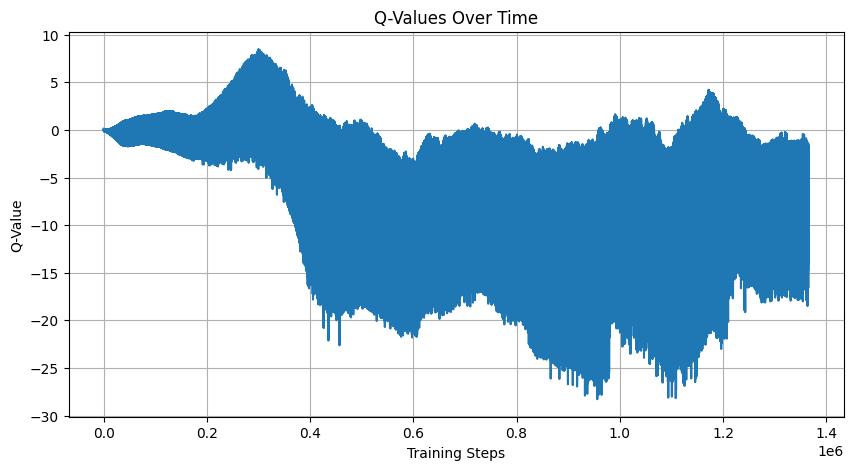

Run 32, Episodes: 8000


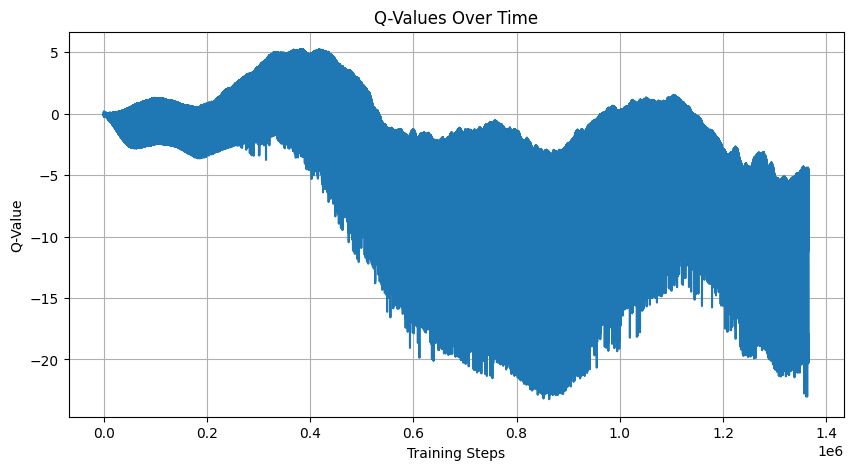

Run 33, Episodes: 10000


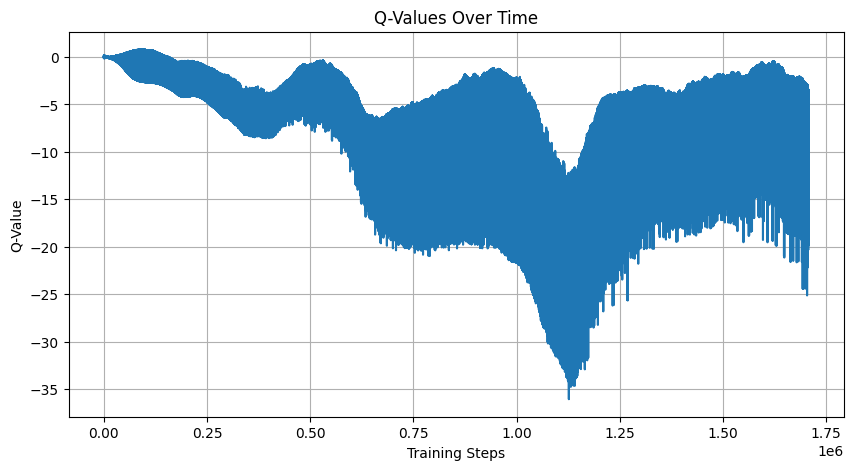

Run 34, Episodes: 10000


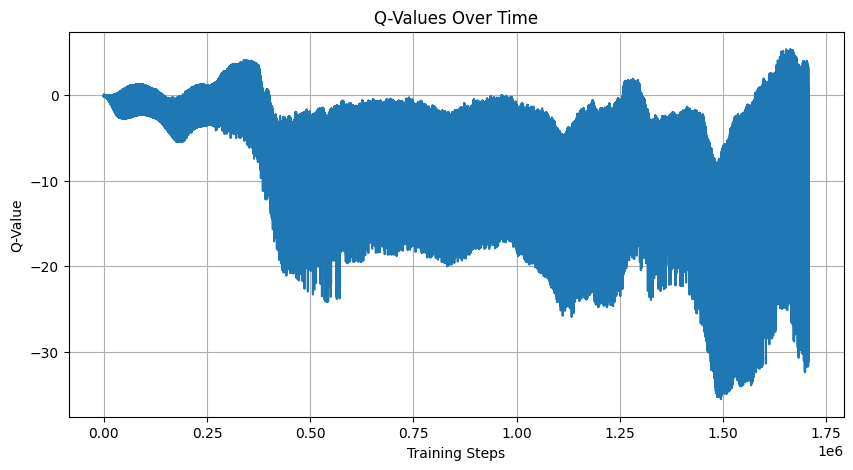

Run 35, Episodes: 10000


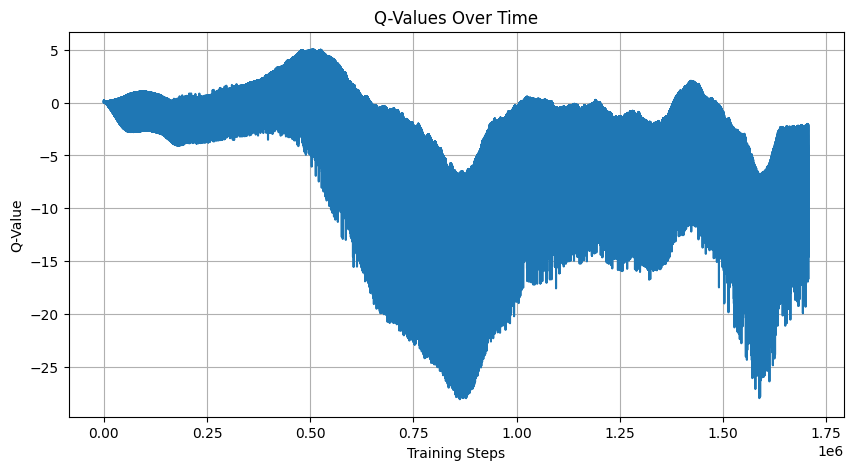

Run 36, Episodes: 8000


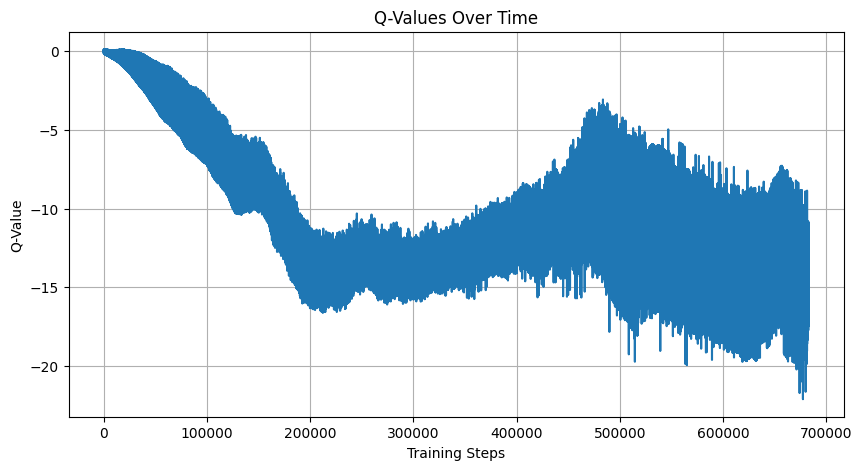

Run 37, Episodes: 8000


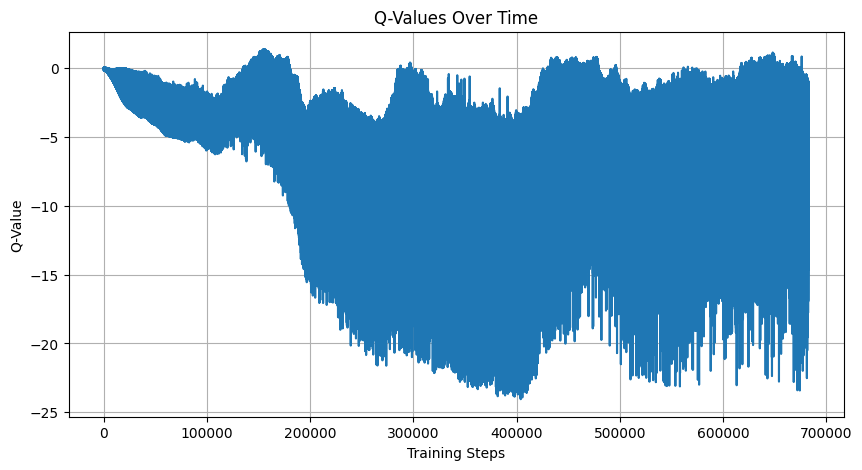

Run 38, Episodes: 8000


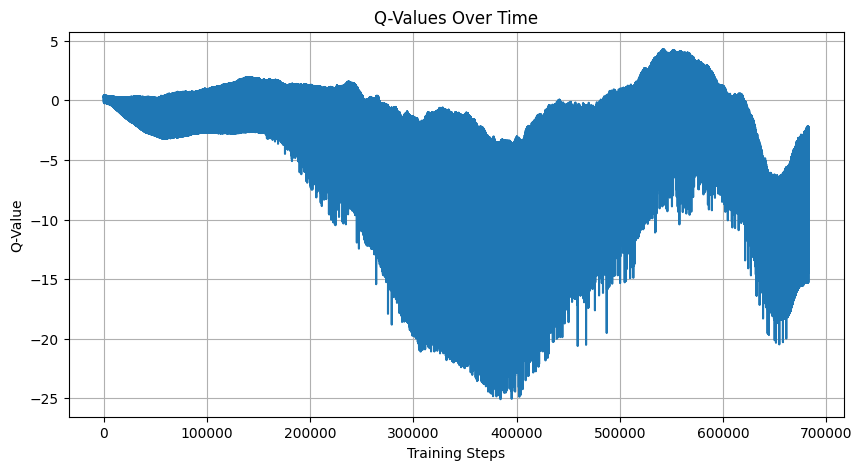

Run 39, Episodes: 10000


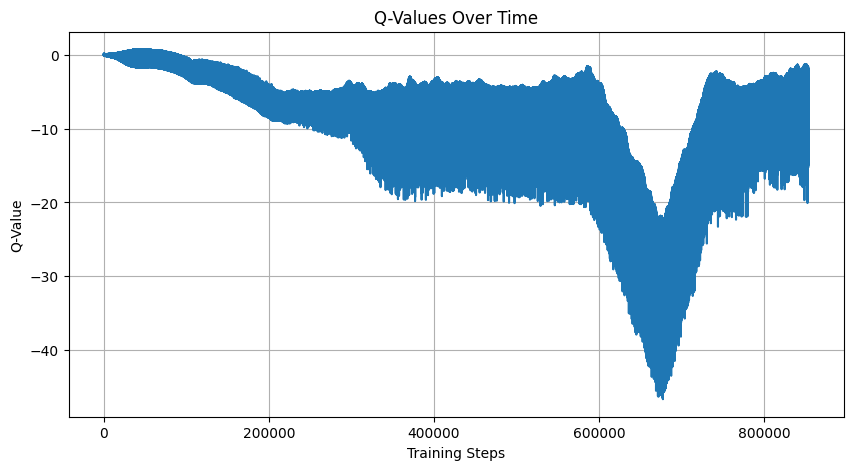

Run 40, Episodes: 10000


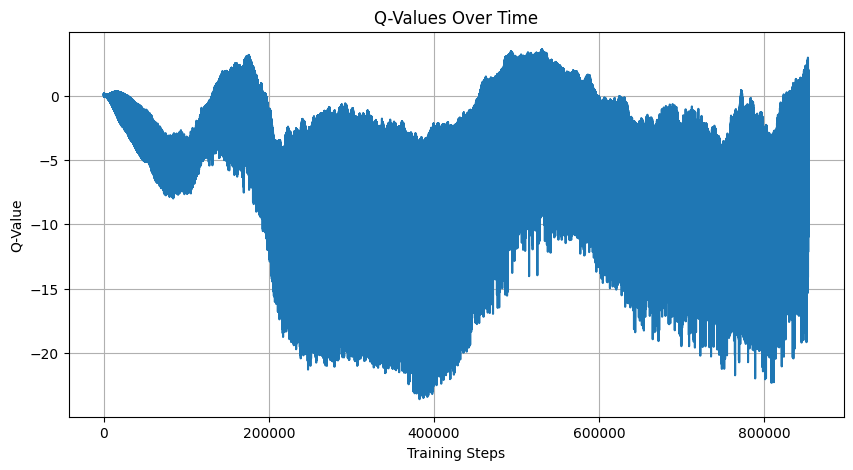

Run 41, Episodes: 10000


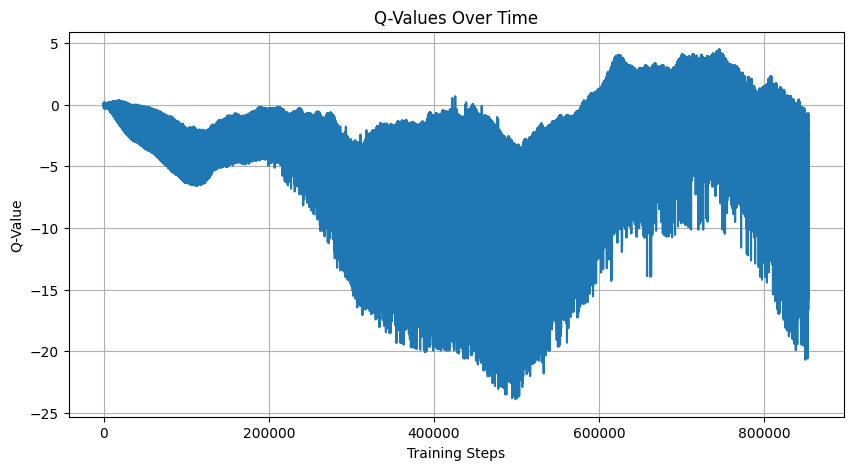

Run 42, Episodes: 8000


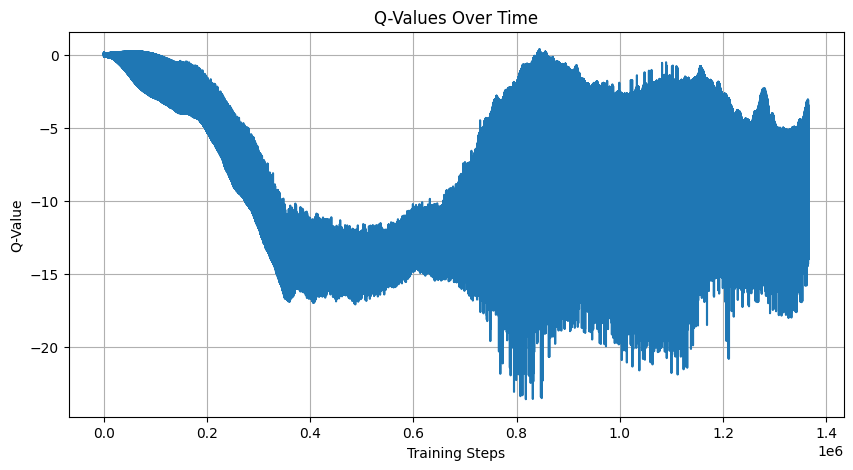

Run 43, Episodes: 8000


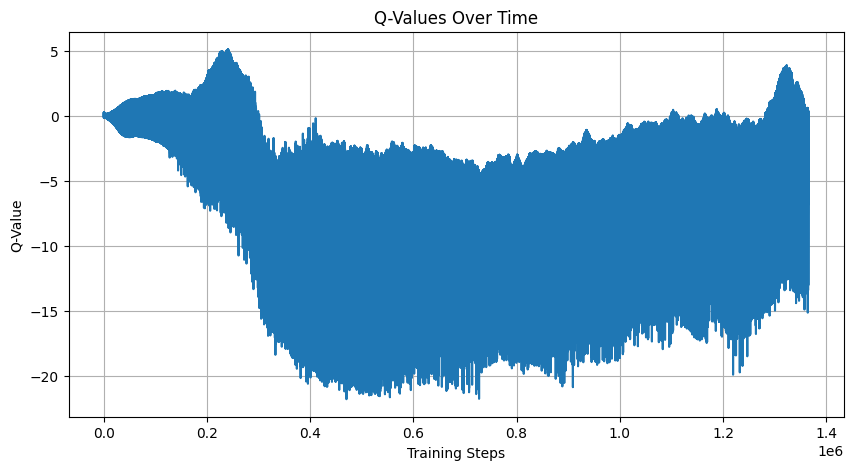

Run 44, Episodes: 8000


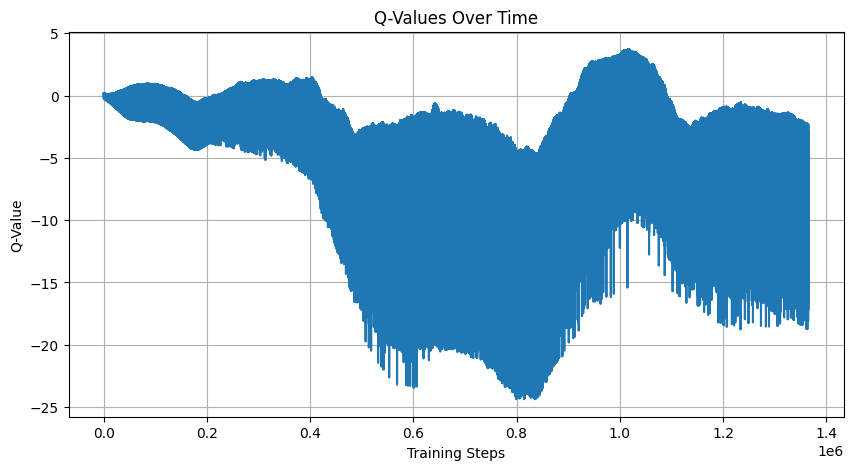

Run 45, Episodes: 10000


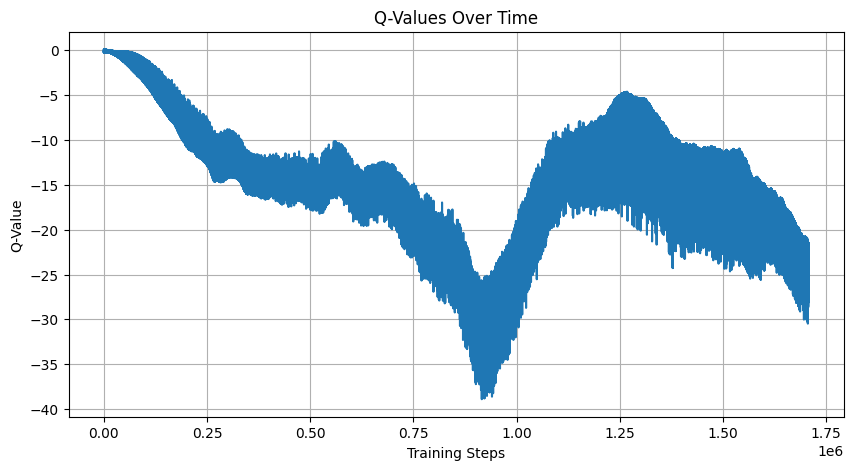

Run 46, Episodes: 10000


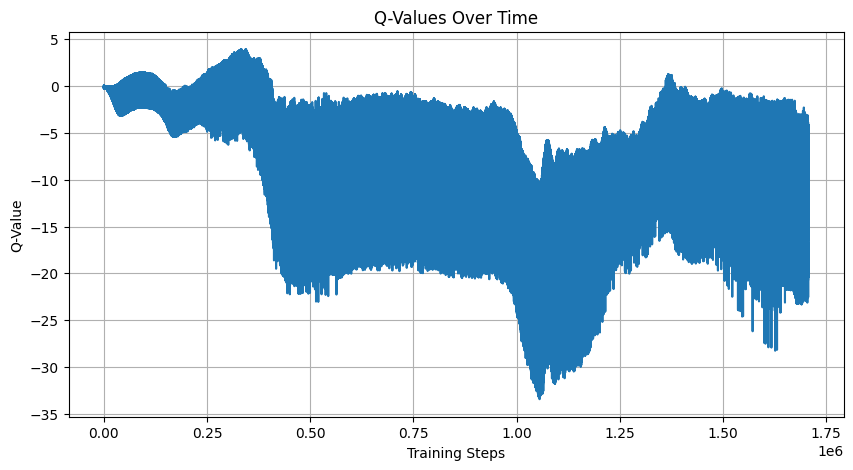

Run 47, Episodes: 10000


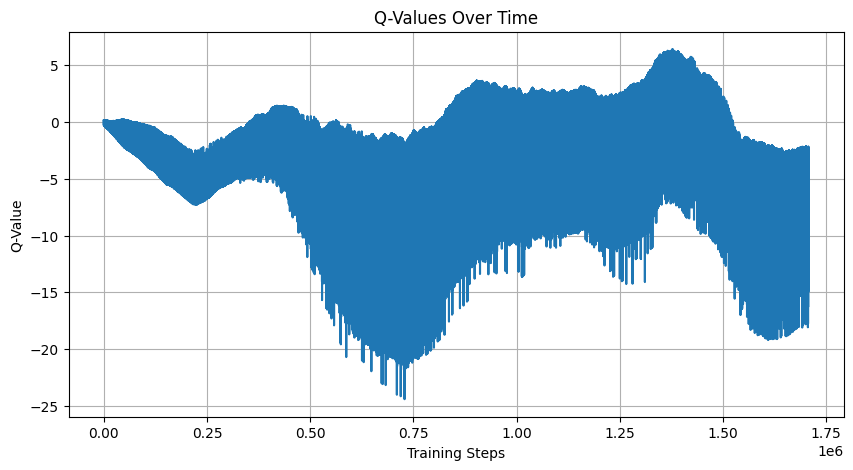

Run 48, Episodes: 8000


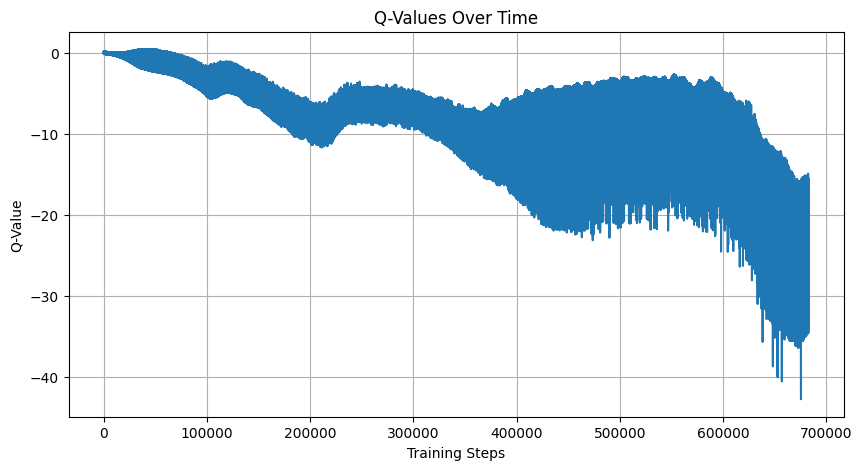

Run 49, Episodes: 8000


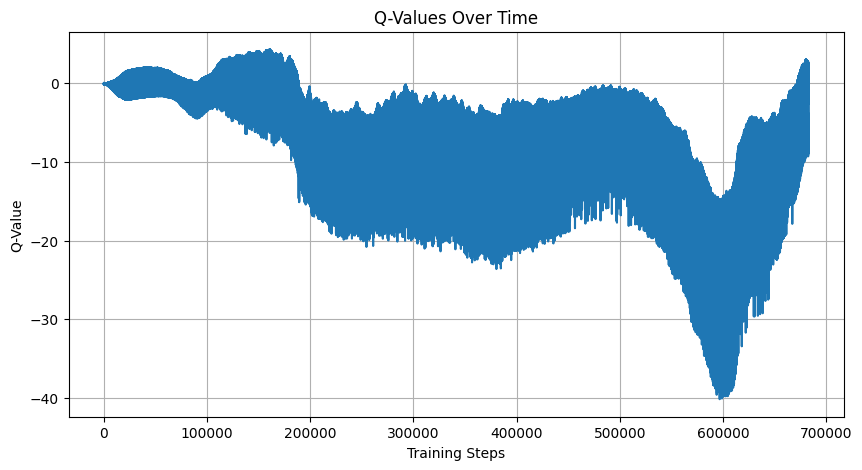

Run 50, Episodes: 8000


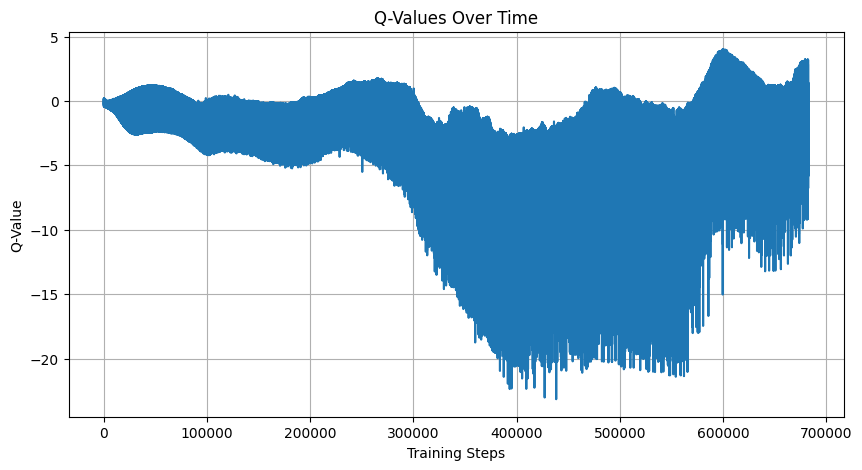

Run 51, Episodes: 10000


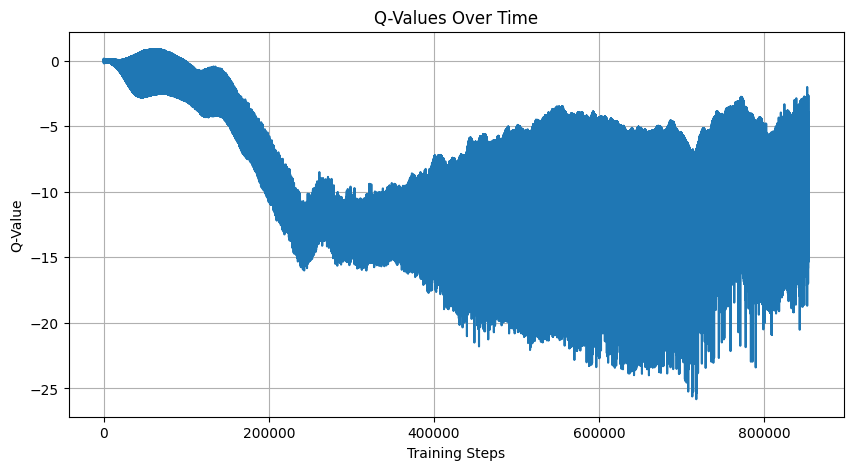

Run 52, Episodes: 10000


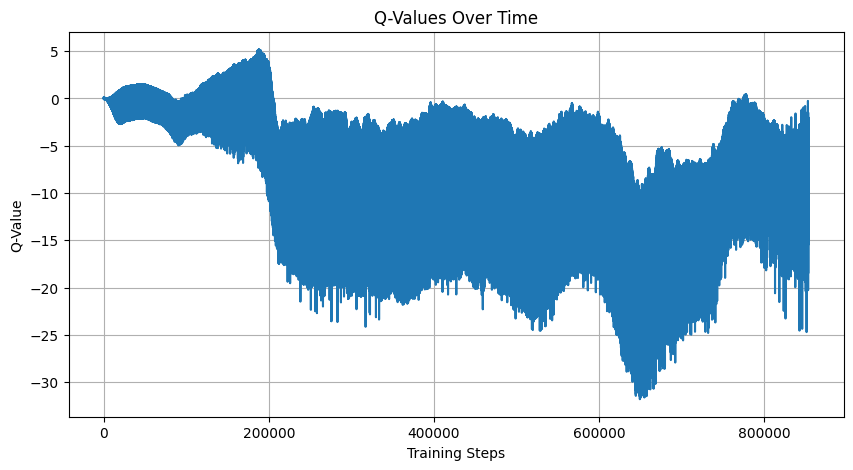

Run 53, Episodes: 10000


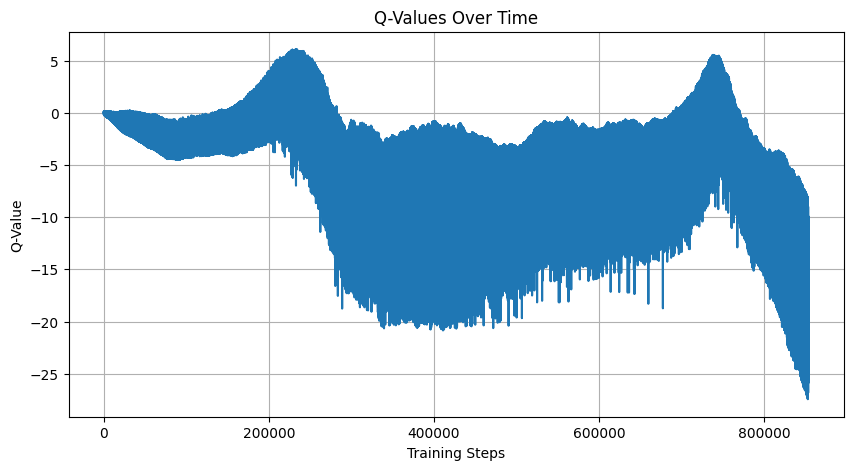

Run 54, Episodes: 8000


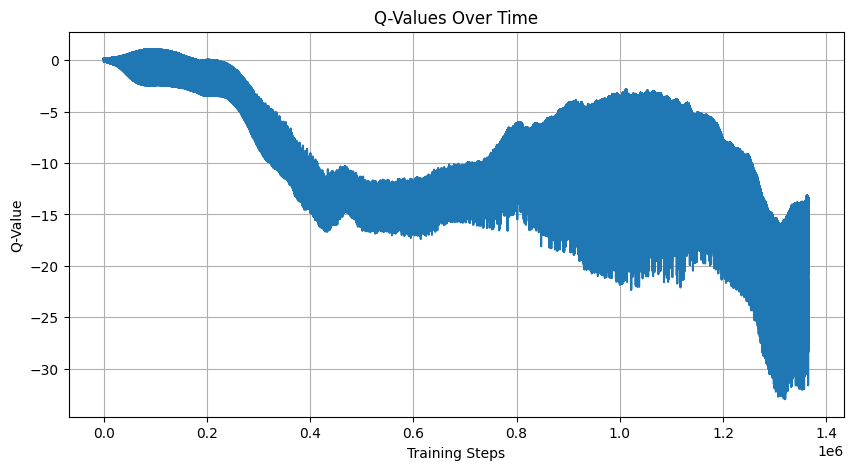

Run 55, Episodes: 8000


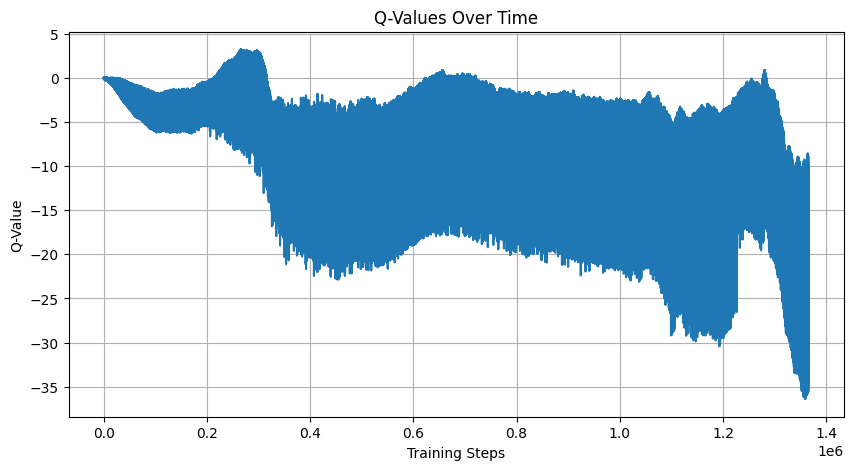

Run 56, Episodes: 8000


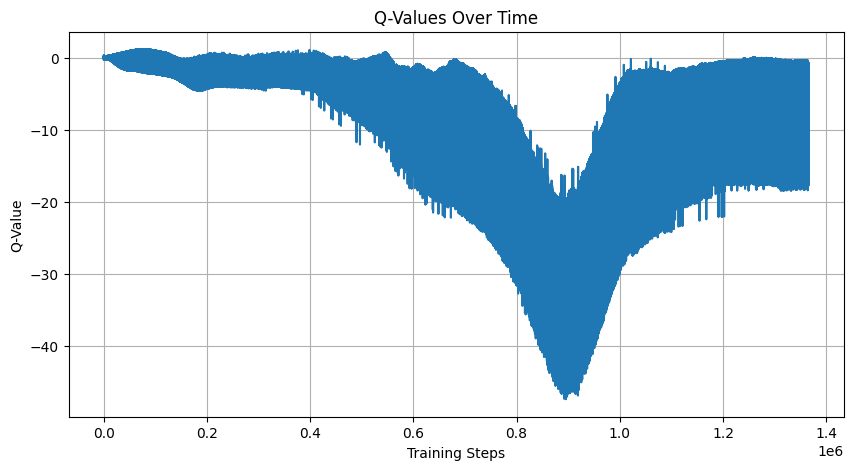

Run 57, Episodes: 10000


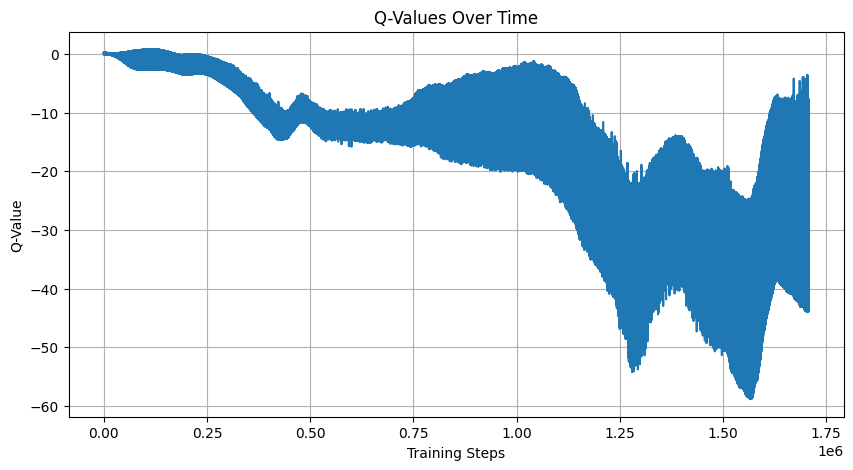

Run 58, Episodes: 10000


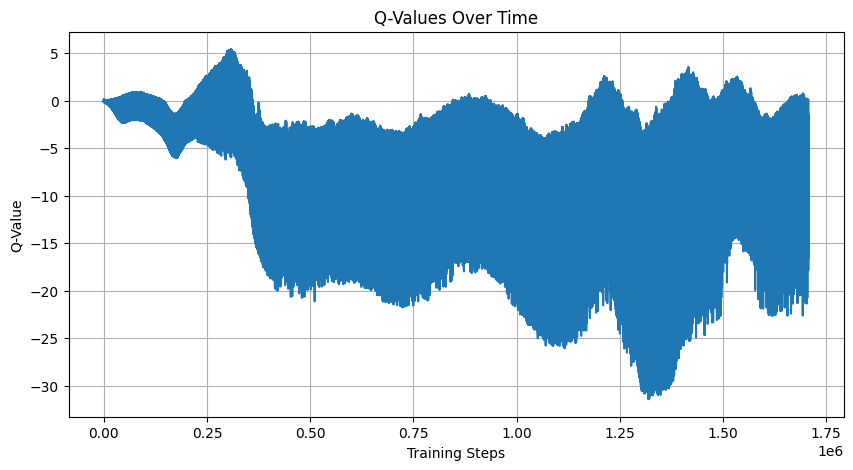

Run 59, Episodes: 10000


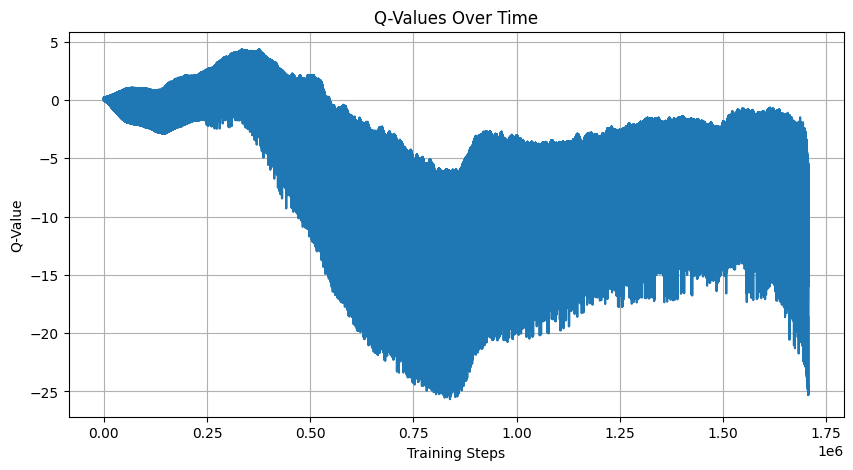

Run 60, Episodes: 8000


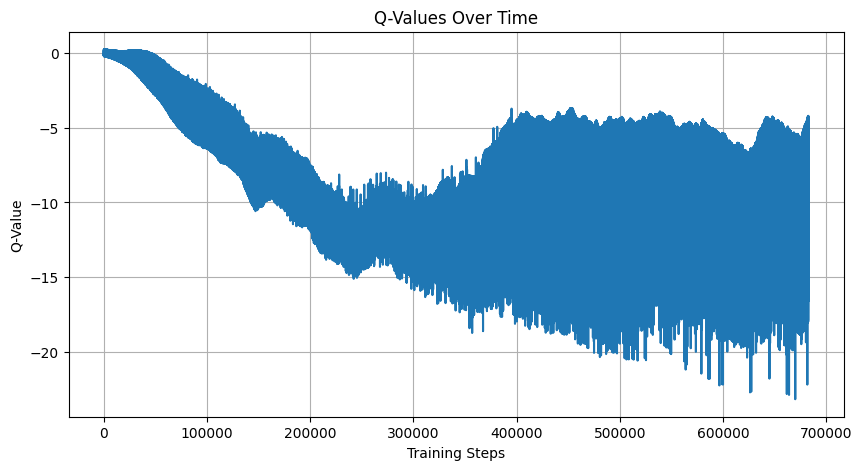

Run 61, Episodes: 8000


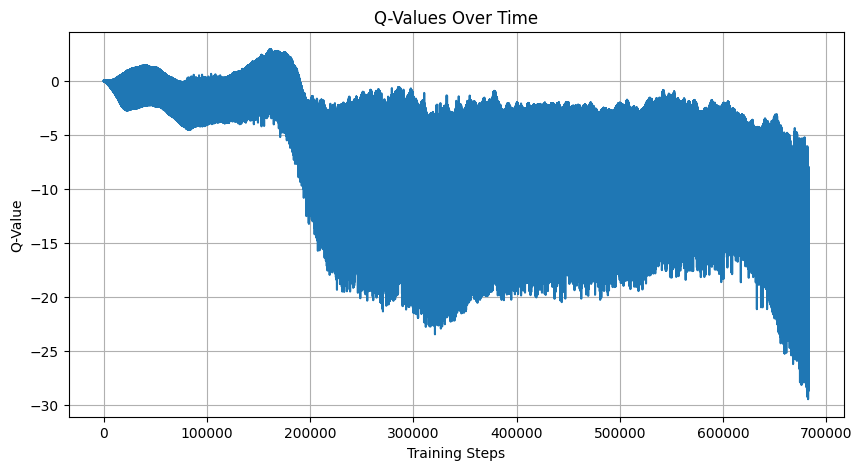

Run 62, Episodes: 8000


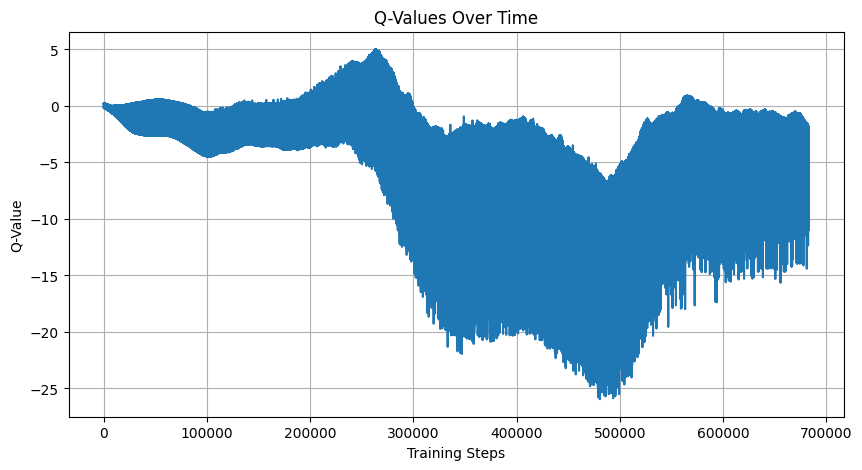

Run 63, Episodes: 10000


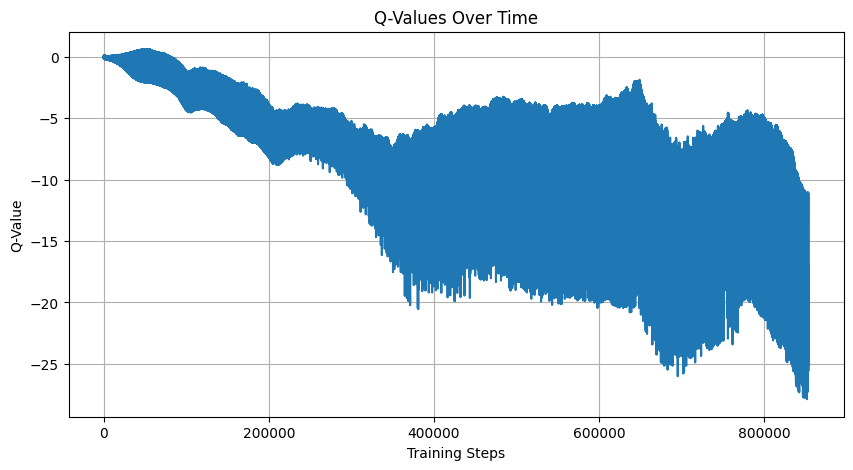

Run 64, Episodes: 10000


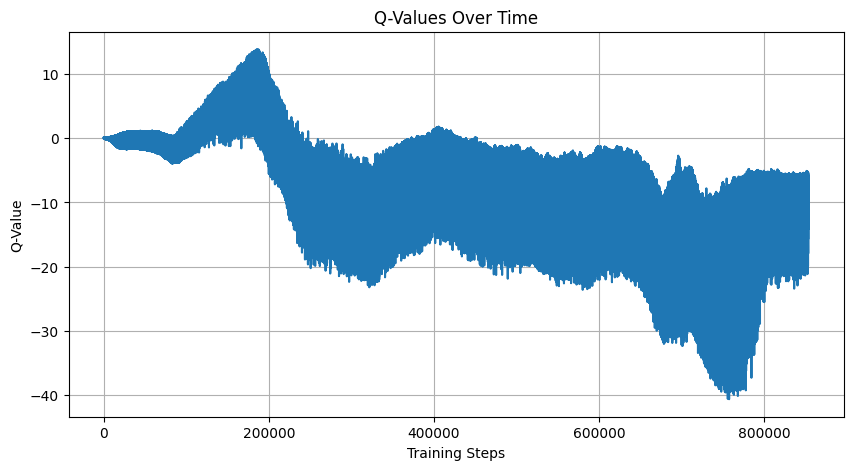

Run 65, Episodes: 10000


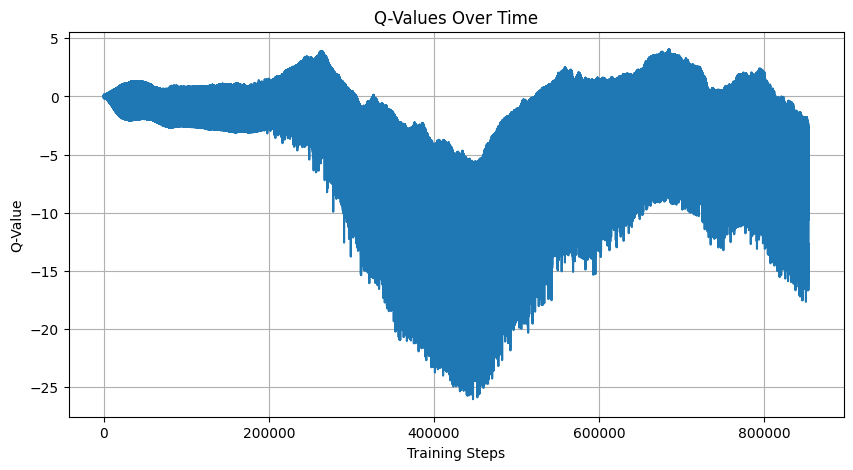

Run 66, Episodes: 8000


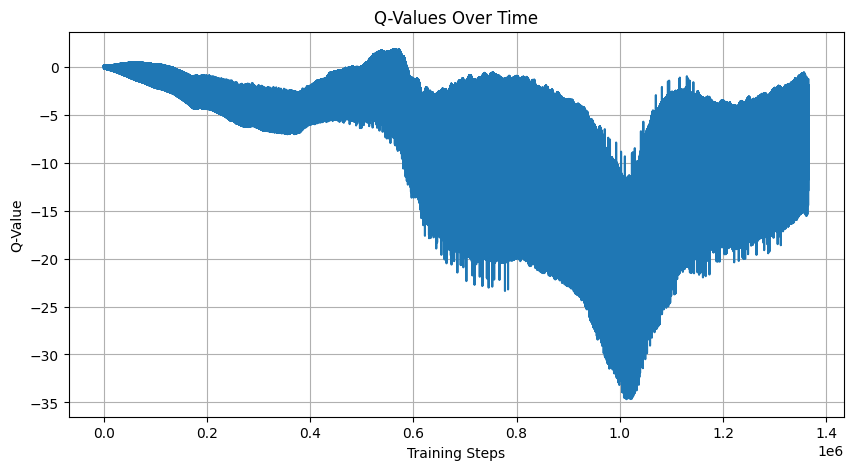

Run 67, Episodes: 8000


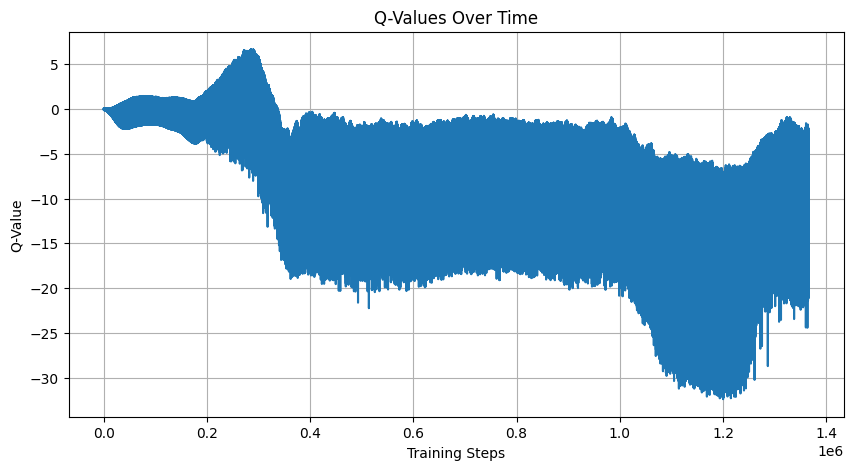

Run 68, Episodes: 8000


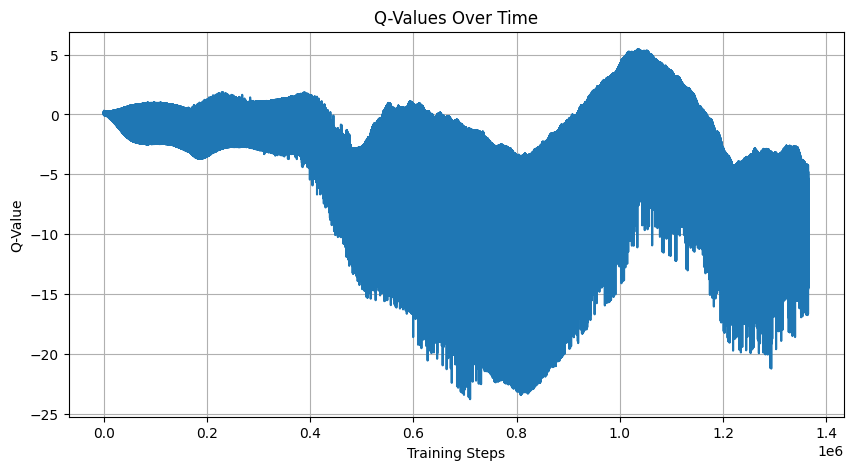

Run 69, Episodes: 10000


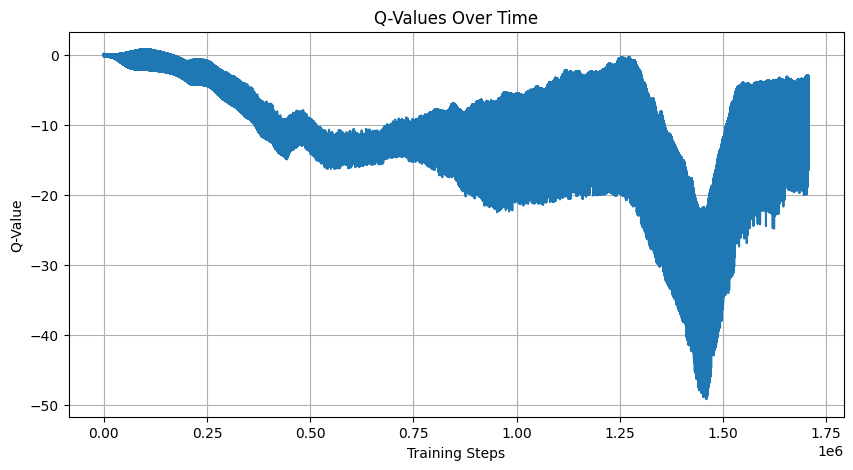

Run 70, Episodes: 10000


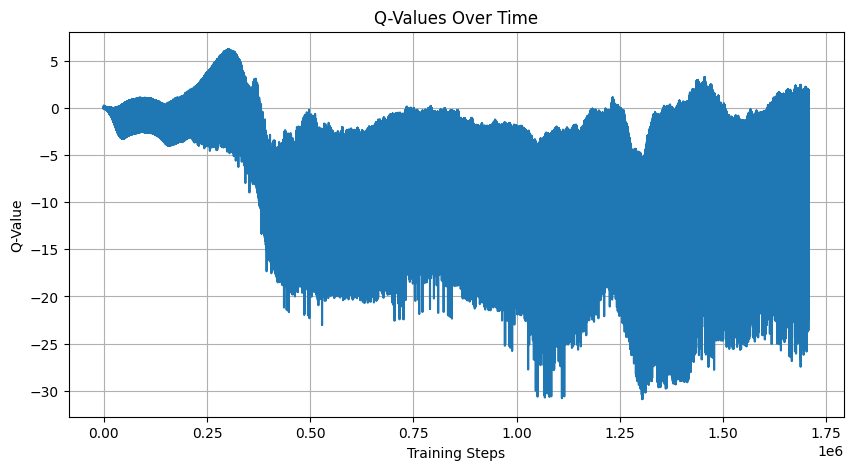

Run 71, Episodes: 10000


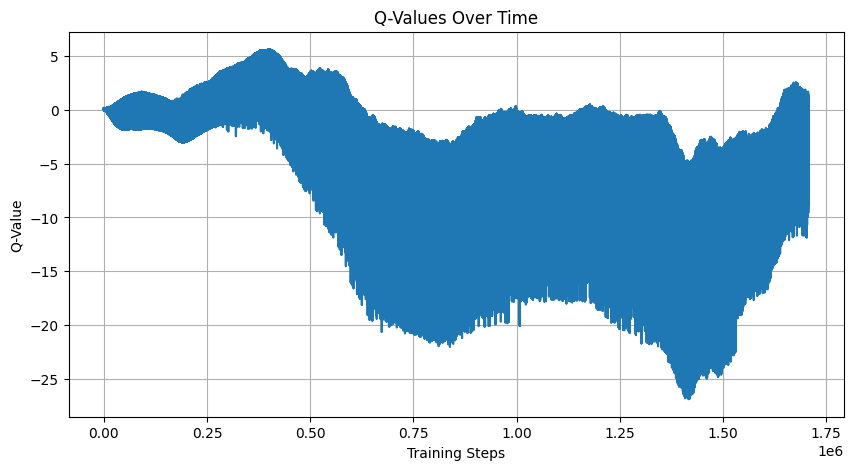

Run 72, Episodes: 8000


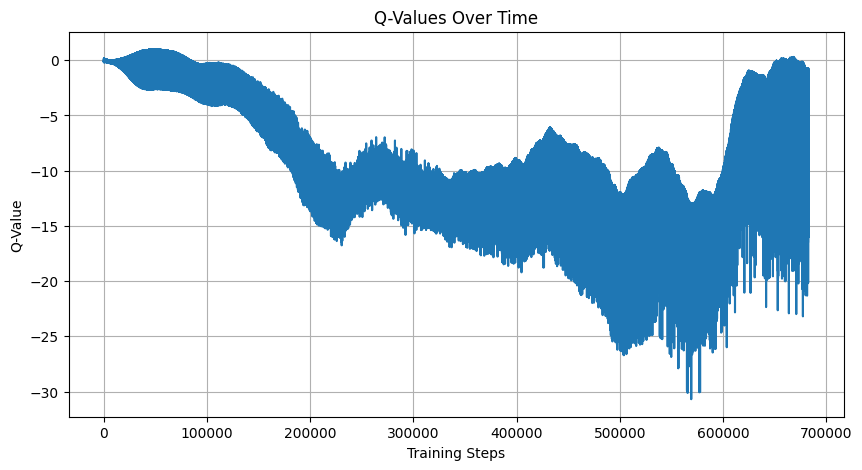

Run 73, Episodes: 8000


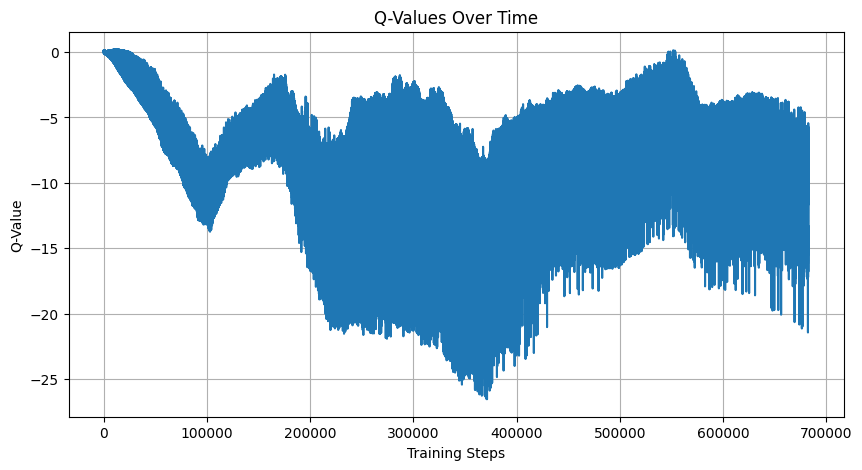

Run 74, Episodes: 8000


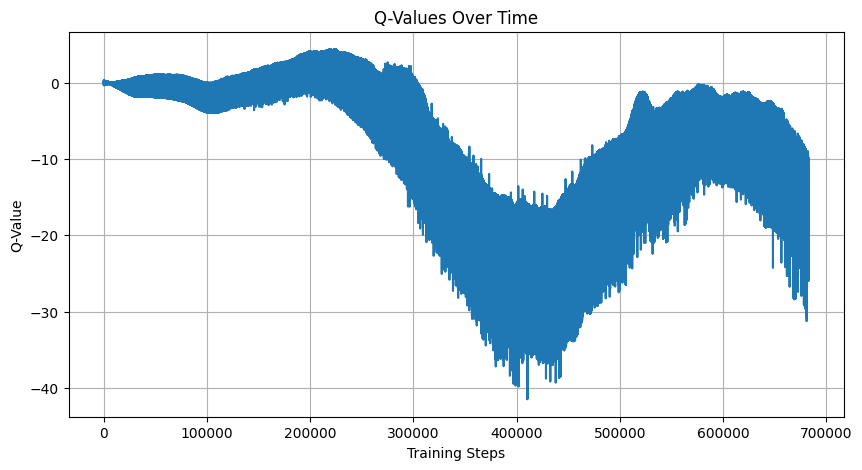

Run 75, Episodes: 10000


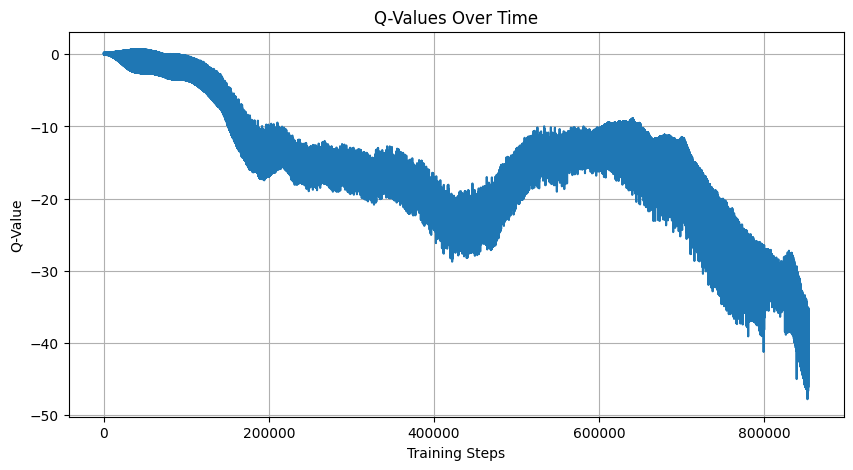

Run 76, Episodes: 10000


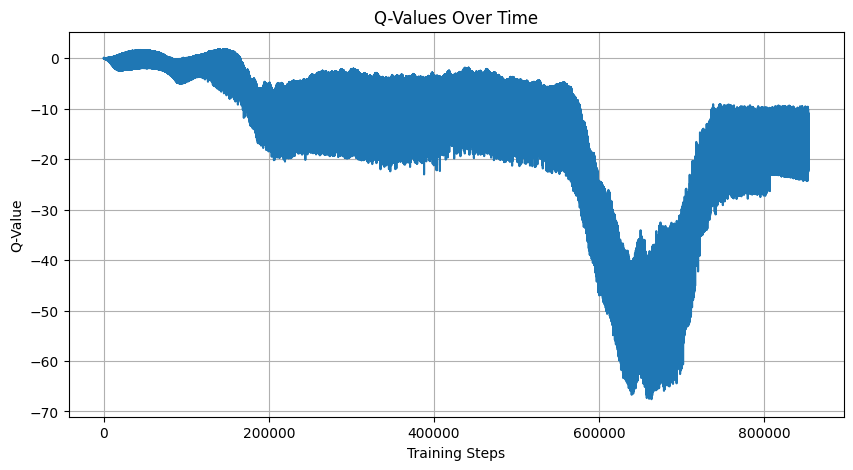

Run 77, Episodes: 10000


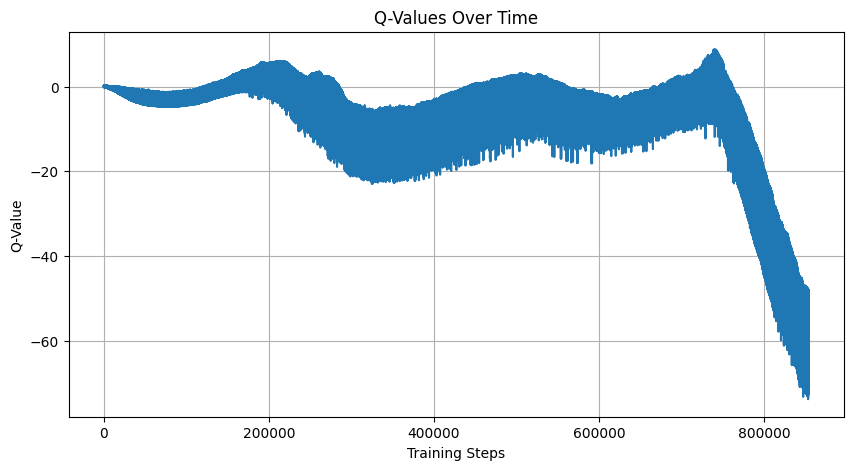

Run 78, Episodes: 8000


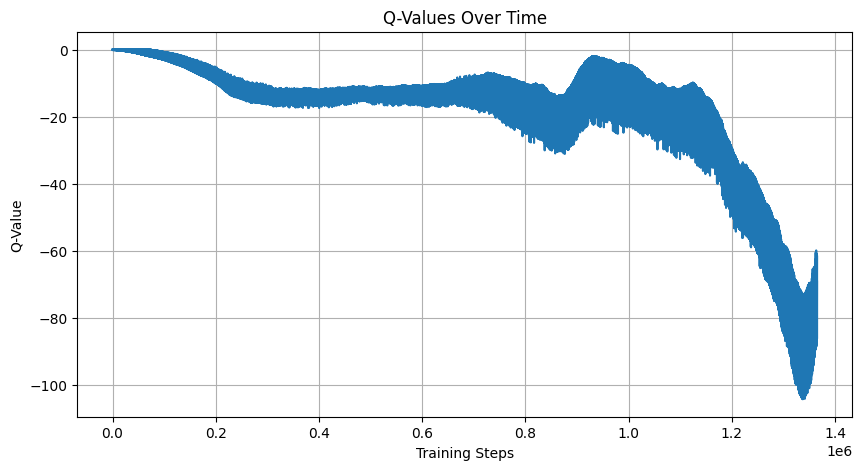

Run 79, Episodes: 8000


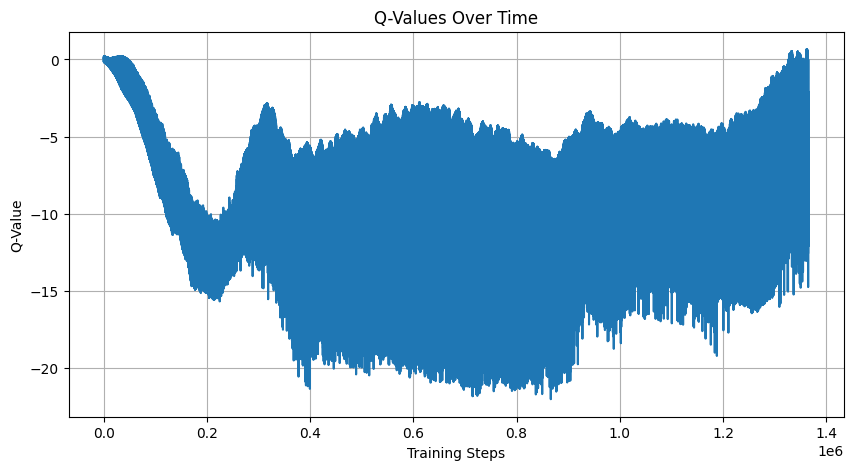

Run 80, Episodes: 8000


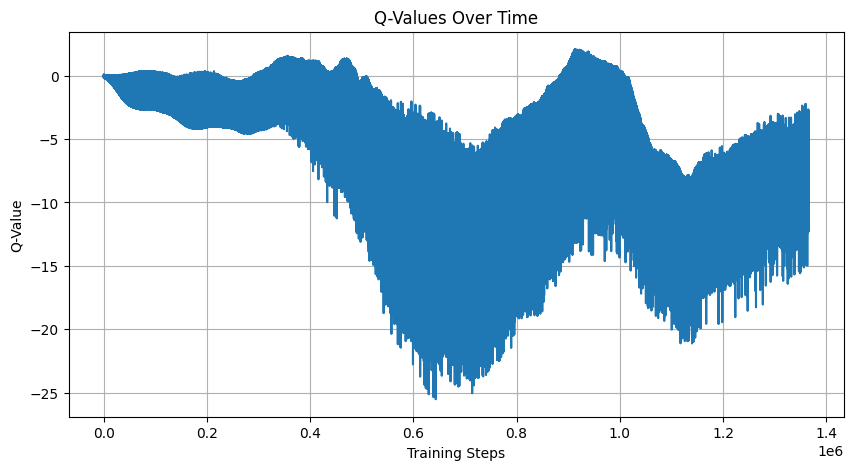

Run 81, Episodes: 10000


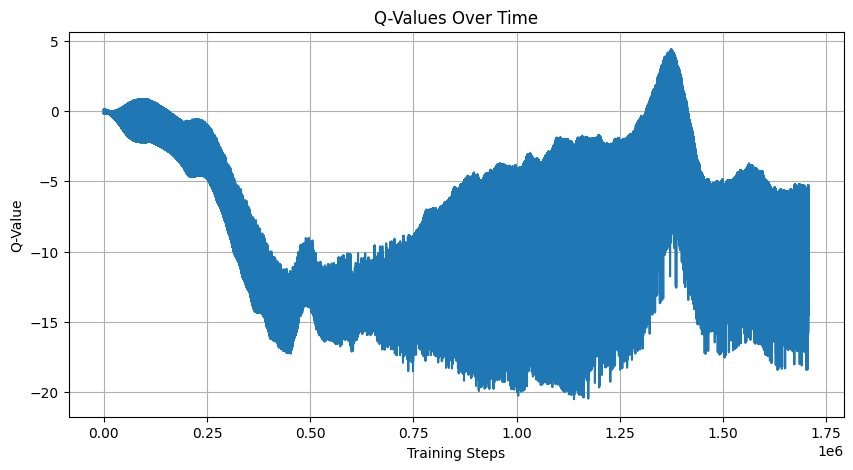

Run 82, Episodes: 10000


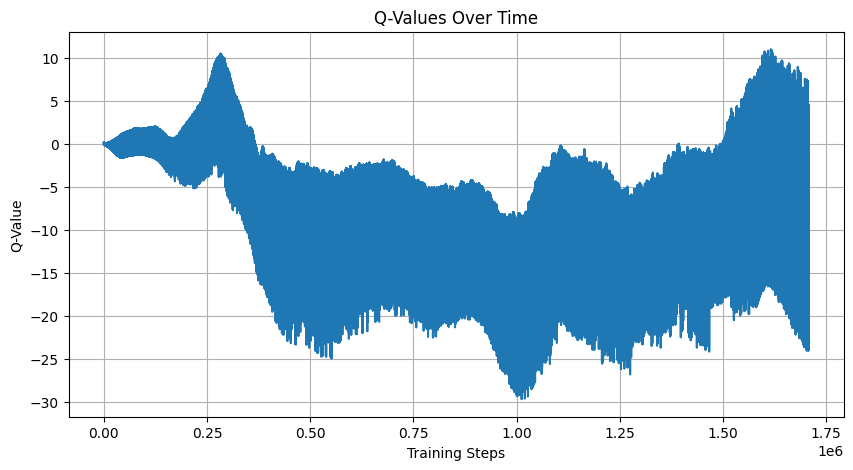

Run 83, Episodes: 10000


In [ ]:
results = []
combo_params = list(generate_param_combinations(hyperparams))
print(f"Totals combinations = {len(combo_params)}")
for i, combo in enumerate(combo_params):
    merged_params = {**shared_params, **combo}
    results.append(run_single_experiment(merged_params, run_id=i))
    

 ## Evaluation

In [ ]:
def get_changed_hyperparams(defaults, current):
    return {
        k: v for k, v in current.items()
        if k not in defaults or defaults[k] != v
    }

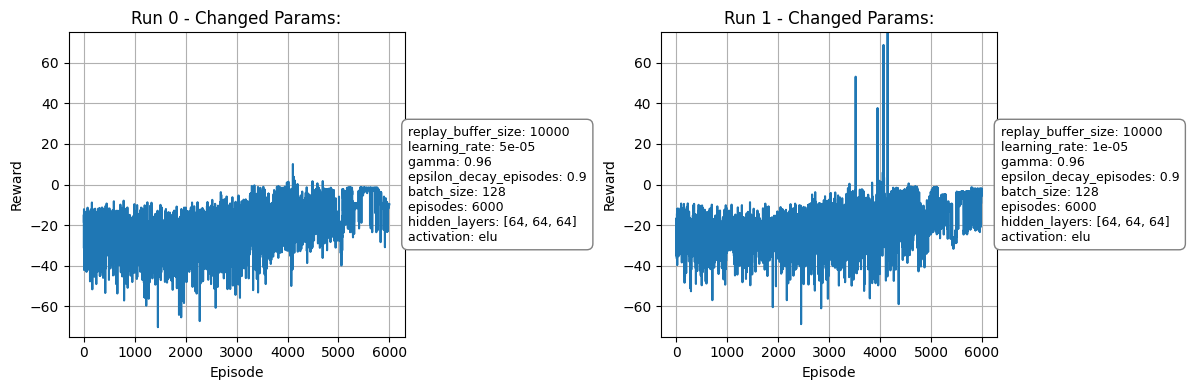

In [ ]:
import math
import matplotlib.pyplot as plt

cols = 2
rows = math.ceil(len(results) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 4))

if len(results) == 1:
    axs = [axs]

# Step 1: Find the max absolute reward for symmetric y-axis
max_reward = max(
    max(abs(min(result["rewards"])), abs(max(result["rewards"])))
    for result in results
)

# Round up to make the graph cleaner
y_limit = math.ceil(max_reward)

for i, result in enumerate(results):
    ax = axs[i // cols][i % cols] if rows > 1 else axs[i % cols]

    rewards = result["rewards"]
    changed = get_changed_hyperparams(shared_params, result["params"])

    ax.plot(rewards)
    ax.set_title(f"Run {i} - Changed Params:")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.grid(True)

    # Step 2: Set a constant center of 0
    ax.set_ylim(-y_limit, y_limit)

    # Annotate changed hyperparameters
    annotation = "\n".join([f"{k}: {v}" for k, v in changed.items()])
    ax.text(1.01, 0.5, annotation, transform=ax.transAxes,
            fontsize=9, verticalalignment='center',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

# Hide any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols][j % cols] if rows > 1 else axs[j % cols])

fig.tight_layout()
plt.savefig("comparison_plot2.png")
plt.show()


In [ ]:
import pandas as pd
csv_data = []
for i, result in enumerate(results):
    param_row = {**result["params"]}
    param_row["run_id"] = i
    param_row["mean_reward"] = sum(result["rewards"]) / len(result["rewards"])
    param_row["max_reward"] = max(result["rewards"])
    param_row["min_reward"] = min(result["rewards"])
    csv_data.append(param_row)

df = pd.DataFrame(csv_data)
df.to_csv("results_log2.csv", index=False)
print("Saved results to results_log.csv")

Saved results to results_log.csv


In [ ]:
# plt.figure(figsize=(10, 5))
# plt.hist(reward_log, bins=10, edgecolor='black')
# plt.title("Reward Distribution")
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()
